<a href="https://colab.research.google.com/github/ArhamAkhtarAlam/-quantum-algorithms/blob/main/shors_algorithm_on_quantum_computer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shor's algorithm

*Usage estimate: Three seconds on an Eagle r3 processor (NOTE: This is an estimate only. Your runtime might vary.)*

[Shor's algorithm,](https://epubs.siam.org/doi/abs/10.1137/S0036144598347011) developed by Peter Shor in 1994, is a groundbreaking quantum algorithm for factoring integers in polynomial time. Its significance lies in its ability to factor large integers exponentially faster than any known classical algorithm, threatening the security of widely used cryptographic systems like RSA, which rely on the difficulty of factoring large numbers. By efficiently solving this problem on a sufficiently powerful quantum computer, Shor's algorithm could revolutionize fields such as cryptography, cybersecurity, and computational mathematics, underscoring the transformative power of quantum computation.

This tutorial focuses on demonstrating Shor's algorithm by factoring 15 on a quantum computer.

First, we define the order finding problem and construct corresponding circuits from the quantum phase estimation protocol. Next, we run the order finding circuits on real hardware using shortest-depth circuits we can transpile. The last section completes Shor's algorithm by connecting the order finding problem to integer factorization.

We end the tutorial with a discussion on other demonstrations of Shor's algorithm on real hardware, focusing on both generic implementations and those tailored to factoring specific integers such as 15 and 21.



Note: This tutorial focuses more on the implementation and demonstration of the circuits concerning Shor's algorithm. For an in-depth educational resource on the material, please refer to the [Fundamentals of quantum algorithms](/learning/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/introduction) course by Dr. John Watrous, and papers in the [References](#references) section.



### Requirements

Before starting this tutorial, ensure that you have the following installed:

*   Qiskit SDK v2.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
*   Qiskit Runtime v0.40 or later (`pip install qiskit-ibm-runtime`)



### Setup



In [28]:
!pip install pylatexenc
!pip install qiskit_ibm_runtime
import numpy as np
import pandas as pd
from fractions import Fraction
from math import floor, gcd, log

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.transpiler import CouplingMap, generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

## Step 1: Map classical inputs to a quantum problem



### Background

Shor's algorithm for integer factorization utilizes an intermediary problem known as the *order finding* problem. In this section, we demonstrate how to solve the order finding problem using *quantum phase estimation*.



### Phase estimation problem

In the phase estimation problem, we're given a quantum state $\ket{\psi}$ of $n$ qubits, along with a unitary quantum circuit that acts on $n$ qubits. We're promised that $\ket{\psi}$ is an eigenvector of the unitary matrix $U$ that describes the action of the circuit, and our goal is to compute or approximate the eigenvalue $\lambda = e^{2 \pi i \theta}$ to which $\ket{\psi}$ corresponds. In other words, the circuit should output an approximation to the number $\theta \in [0, 1)$ satisfying $U \ket{\psi}= e^{2 \pi i \theta} \ket{\psi}.$
The goal of the phase estimation circuit is to approximate $\theta$ in $m$ bits. Mathematically speaking, we would like to find $y$ such that $\theta \approx y / 2^m$, where $y \in {0, 1, 2, \dots, 2^{m-1}}$. The following image shows the quantum circuit that estimates $y$ in $m$ bits by making a measurement on $m$ qubits.



![Quantum phase estimation circuit](/learning/images/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/phase-estimation-procedure.svg)



In the above circuit, top $m$ qubits are initiated in the $\ket{0^m}$ state, and the bottom $n$ qubits are initiated in $\ket{\psi}$, which is promised to be an eigenvector of $U$. The first ingredient in the phase estimation circuit are the controlled-unitary operations that are responsible for performing a *phase kickback* to their corresponding control qubit. These controlled unitaries are exponentiated in accordance to the position of the control qubit, ranging from the least significant bit to the most significant bit. Since $\ket{\psi}$ is an eigenvector of $U$, the state of the bottom $n$ qubits is not affected by this operation, but the phase information of the eigenvalue propagates to the top $m$ qubits.



It turns out that after the phase kickback operation via controlled-unitaries, all possible states of the top $m$ qubits are orthonormal to each other for each eigenvector $\ket{\psi}$ of the unitary $U$. Therefore, these states are perfectly distinguishable, and we can rotate the basis they form back to the computational basis to make a measurement. A mathematical analysis shows that this rotation matrix corresponds to the inverse quantum Fourier transform (QFT) in $2^m$-dimensional Hilbert space. The intuition behind this is that the periodic structure of the modular exponentiation operators is encoded in the quantum state, and the QFT converts this periodicity into measurable peaks in the frequency domain.

For a more in-depth understanding of why the QFT circuit is employed in Shor's algorithm, we refer the reader to the [Fundamentals of quantum algorithms](/learning/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/introduction) course.



We are now ready to use the phase estimation circuit for order finding.



### Order finding problem

To define the order finding problem, we begin with some number theory concepts. First, for any given positive integer $N$, define the set $\mathbb{Z}_N$ as $\mathbb{Z}_N = \{0, 1, 2, \dots, N-1\}.$
All arithmetic operations in $\mathbb{Z}_N$ are performed modulo $N$. In particular, all elements $a \in \mathbb{Z}_n$ that are coprime with $N$ are special and constitute $\mathbb{Z}^*_N$ as $\mathbb{Z}^*_N = \{ a \in \mathbb{Z}_N : \mathrm{gcd}(a, N)=1 \}.$
For an element $a \in \mathbb{Z}^*_N$, the smallest positive integer $r$ such that $a^r \equiv 1 \; (\mathrm{mod} \; N)$ is defined as the *order* of $a$ modulo $N$. As we will see later, finding the order of an $a \in \mathbb{Z}^*_N$ will allow us factor $N$.



To construct the order finding circuit from the phase estimation circuit, we need two considerations. First, we need to define the unitary $U$ that will allow us to find the order $r$, and second, we need to define an eigenvector $\ket{\psi}$ of $U$ to prepare the initial state of the phase estimation circuit.

To connect the order finding problem to phase estimation, we consider the operation defined on a system whose classical states correspond to $\mathbb{Z}_N$, where we multiply by a fixed element $a \in \mathbb{Z}^*_N$. In particular, we define this multiplication operator $M_a$ such that $M_a \ket{x} = \ket{ax \; (\mathrm{mod} \; N)}$ for each $x \in \mathbb{Z}_N$. Note that it's implicit that we're taking the product modulo $N$ inside of the ket on the right-hand side of the equation. A mathematical analysis shows that $M_a$ is an unitary operator. Furthermore, it turns out that $M_a$ has eigenvector and eigenvalue pairs that allow us to connect the order $r$ of $a$ to the phase estimation problem. Specifically, for any choice of $j \in \{0, \dots, r-1\}$, we have that $\ket{\psi_j} = \frac{1}{\sqrt{r}} \sum^{r-1}_{k=0} \omega^{-jk}_{r} \ket{a^k}$ is an eigenvector of $M_a$ whose corresponding eigenvalue is $\omega^{j}_{r}$, where $\omega^{j}_{r} = e^{2 \pi i \frac{j}{r}}.$



By observation, we see that a convenient eigenvector/eigenvalue pair is the state $\ket{\psi_1}$ with $\omega^{1}_{r} = e^{2 \pi i \frac{1}{r}}$. Therefore, if we could find the eigenvector $\ket{\psi_1}$, we could estimate the phase $\theta=1/r$ with our quantum circuit and therefore get an estimate of the order $r$. However, it's not easy to do so, and we need to consider an alternative.

Let's consider what the circuit would result in if we prepare the computational state $\ket{1}$ as the initial state. This is not an eigenstate of $M_a$, but it is the uniform superposition of the eigenstates we just described above. In other words, the following relation holds. $\ket{1} = \frac{1}{\sqrt{r}} \sum^{r-1}_{k=0} \ket{\psi_k}$
The implication of the above equation is that if we set the initial state to $\ket{1}$, we will obtain precisely the same measurement result as if we had chosen $k \in \{ 0, \dots, r-1\}$ uniformly at random and used $\ket{\psi_k}$ as an eigenvector in the phase estimation circuit. In other words, a measurement of the top $m$ qubits yields an approximation $y / 2^m$ to the value $k / r$ where  $k \in \{ 0, \dots, r-1\}$ is chosen uniformly at random. This allows us to learn $r$ with a high degree of confidence after several independent runs, which was our goal.



### Modular exponentiation operators

So far, we linked the phase estimation problem to the order finding problem by defining $U = M_a$ and $\ket{\psi} = \ket{1}$ in our quantum circuit. Therefore, the last remaining ingredient is to find an efficient way to define modular exponentials of $M_a$ as $M_a^k$ for $k = 1, 2, 4, \dots, 2^{m-1}$.
To perform this computation, we find that for any power $k$ we choose, we can create a circuit for $M_a^k$ not by iterating $k$ times the circuit for $M_a$, but instead by computing $b = a^k \; \mathrm{mod} \; N$ and then using the circuit for $M_b$. Since we only need the powers that are powers of 2 themselves, we can do this classically efficiently by using iterative squaring.



## Step 2: Optimize problem for quantum hardware execution



### Specific example with $N = 15$ and $a=2$

We can pause here to discuss a specific example and construct the order finding circuit for $N=15$. Note that possible nontrivial $a \in \mathbb{Z}_N^*$ for $N=15$ are $a \in \{2, 4, 7, 8, 11, 13, 14 \}$. For this example, we choose $a=2$. We will construct the $M_2$ operator and the modular exponentiation operators $M_2^k$.



The action of $M_2$ on the computational basis states is as follows.
$M_2 \ket{0} = \ket{0} \quad M_2 \ket{5} = \ket{10} \quad M_2 \ket{10} = \ket{5}$
$M_2 \ket{1} = \ket{2} \quad M_2 \ket{6} = \ket{12} \quad M_2 \ket{11} = \ket{7}$
$M_2 \ket{2} = \ket{4} \quad M_2 \ket{7} = \ket{14} \quad M_2 \ket{12} = \ket{9}$
$M_2 \ket{3} = \ket{6} \quad M_2 \ket{8} = \ket{1} \quad M_2 \ket{13} = \ket{11}$
$M_2 \ket{4} = \ket{8} \quad M_2 \ket{9} = \ket{3} \quad M_2 \ket{14} = \ket{13}$
By observation, we can see that the basis states are shuffled, so we have a permutation matrix. We can construct this operation on four qubits with swap gates. Below, we construct the $M_2$ and the controlled-$M_2$ operations.



In [29]:
!pip install pylatexenc
def M2mod15():
    """
    M2 (mod 15)
    """
    b = 2
    U = QuantumCircuit(4)

    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)

    U = U.to_gate()
    U.name = f"M_{b}"

    return U

In [30]:
# Get the M2 operator
M2 = M2mod15()

# Add it to a circuit and plot
circ = QuantumCircuit(4)
circ.compose(M2, inplace=True)
print(circ.decompose(reps=2).draw(output="text", fold=-1))

                                        ┌───┐     
q_0: ────────────────────────────────■──┤ X ├──■──
                         ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ─────────────────■──┤ X ├──■──┤ X ├──■──┤ X ├
          ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘
q_2: ──■──┤ X ├──■──┤ X ├──■──┤ X ├───────────────
     ┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘               
q_3: ┤ X ├──■──┤ X ├──────────────────────────────
     └───┘     └───┘                              


In [31]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

# Create a simple circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

# Try drawing the simple circuit
print(qc.draw(output='text', fold=-1))
# plt.show() # No need to call plt.show() with text output

     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


In [32]:
%matplotlib inline

In [33]:
!pip install qiskit[visualization]

In [34]:
def controlled_M2mod15():
    """
    Controlled M2 (mod 15)
    """
    b = 2
    U = QuantumCircuit(4)

    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)

    U = U.to_gate()
    U.name = f"M_{b}"
    c_U = U.control()

    return c_U

In [35]:
# Get the controlled-M2 operator
controlled_M2 = controlled_M2mod15()

# Add it to a circuit and plot
circ = QuantumCircuit(5)
circ.compose(controlled_M2, inplace=True)
print(circ.decompose(reps=1).draw(output="text", fold=-1))

                                                  
q_0: ──■────■────■────■────■────■────■────■────■──
       │    │    │    │    │    │    │  ┌─┴─┐  │  
q_1: ──┼────┼────┼────┼────┼────┼────■──┤ X ├──■──
       │    │    │    │  ┌─┴─┐  │  ┌─┴─┐└─┬─┘┌─┴─┐
q_2: ──┼────┼────┼────■──┤ X ├──■──┤ X ├──■──┤ X ├
       │  ┌─┴─┐  │  ┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘
q_3: ──■──┤ X ├──■──┤ X ├──■──┤ X ├───────────────
     ┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘               
q_4: ┤ X ├──■──┤ X ├──────────────────────────────
     └───┘     └───┘                              


Gates acting on more than two qubits will be further decomposed into two-qubit gates.



In [36]:
# Get the controlled-M2 operator (assuming circ is the controlled_M2 circuit from the previous cell)
controlled_M2 = controlled_M2mod15() # Redefine controlled_M2
circ = QuantumCircuit(5) # Redefine circ
circ.compose(controlled_M2, inplace=True) # Re-compose controlled_M2

print(circ.decompose(reps=2).draw(output="text", fold=-1))

                                                       ┌───┐                                                             ┌───┐                                                        ┌───┐                                                        ┌───┐                                                             ┌───┐                                                        ┌───┐                                                        ┌───┐                                                             ┌───┐                                                        ┌───┐      
q_0: ───────────────────■─────────────────────■────■───┤ T ├───■─────────────────────■─────────────────────■─────────■───┤ T ├───■─────────────────────■─────────────────────■────■───┤ T ├───■─────────────────────■─────────────────────■────■───┤ T ├───■─────────────────────■─────────────────────■─────────■───┤ T ├───■─────────────────────■─────────────────────■────■───┤ T ├───■─────────────────────■─────────────────────■────■──

Now we need to construct the modular exponentiation operators. To obtain enough precision in the phase estimation, we will use eight qubits for the estimation measurement. Therefore, we need to construct $M_b$ with $b = a^{2^k} \; (\mathrm{mod} \; N)$ for each $k = 0, 1, \dots, 7$.



In [37]:
def a2kmodN(a, k, N):
    """Compute a^{2^k} (mod N) by repeated squaring"""
    for _ in range(k):
        a = int(np.mod(a**2, N))
    return a

In [38]:
k_list = range(8)
b_list = [a2kmodN(2, k, 15) for k in k_list]

print(b_list)

[2, 4, 1, 1, 1, 1, 1, 1]


As we can see from the list of $b$ values, in addition to $M_2$ that we previously constructed, we also need to build $M_4$ and $M_1$. Note that $M_1$ acts trivially on the computational basis states, so it is simply the identity operator.

$M_4$ acts on the computational basis states as follows.
$M_4 \ket{0} = \ket{0} \quad M_4 \ket{5} = \ket{5} \quad M_4 \ket{10} = \ket{10}$
$M_4 \ket{1} = \ket{4} \quad M_4 \ket{6} = \ket{9} \quad M_4 \ket{11} = \ket{14}$
$M_4 \ket{2} = \ket{8} \quad M_4 \ket{7} = \ket{13} \quad M_4 \ket{12} = \ket{3}$
$M_4 \ket{3} = \ket{12} \quad M_4 \ket{8} = \ket{2} \quad M_4 \ket{13} = \ket{7}$
$M_4 \ket{4} = \ket{1} \quad M_4 \ket{9} = \ket{6} \quad M_4 \ket{14} = \ket{11}$

Therefore, this permutation can be constructed with the following swap operation.



In [39]:
def M4mod15():
    """
    M4 (mod 15)
    """
    b = 4
    U = QuantumCircuit(4)

    U.swap(1, 3)
    U.swap(0, 2)

    U = U.to_gate()
    U.name = f"M_{b}"

    return U

In [40]:
# Get the M4 operator
M4 = M4mod15()

# Add it to a circuit and plot
circ = QuantumCircuit(4)
circ.compose(M4, inplace=True)
print(circ.decompose(reps=2).draw(output="text", fold=-1))

               ┌───┐               
q_0: ──■───────┤ X ├───────■───────
       │       └─┬─┘┌───┐  │       
q_1: ──┼────■────┼──┤ X ├──┼────■──
     ┌─┴─┐  │    │  └─┬─┘┌─┴─┐  │  
q_2: ┤ X ├──┼────■────┼──┤ X ├──┼──
     └───┘┌─┴─┐       │  └───┘┌─┴─┐
q_3: ─────┤ X ├───────■───────┤ X ├
          └───┘               └───┘


In [41]:
def controlled_M4mod15():
    """
    Controlled M4 (mod 15)
    """
    b = 4
    U = QuantumCircuit(4)

    U.swap(1, 3)
    U.swap(0, 2)

    U = U.to_gate()
    U.name = f"M_{b}"
    c_U = U.control()

    return c_U

In [42]:
# Get the controlled-M4 operator
controlled_M4 = controlled_M4mod15()

# Add it to a circuit and plot
circ = QuantumCircuit(5)
circ.compose(controlled_M4, inplace=True)
print(circ.decompose(reps=1).draw(output="text", fold=-1))

                                   
q_0: ──■────■────■────■────■────■──
       │  ┌─┴─┐  │    │    │    │  
q_1: ──■──┤ X ├──■────┼────┼────┼──
       │  └─┬─┘  │    │  ┌─┴─┐  │  
q_2: ──┼────┼────┼────■──┤ X ├──■──
     ┌─┴─┐  │  ┌─┴─┐  │  └─┬─┘  │  
q_3: ┤ X ├──■──┤ X ├──┼────┼────┼──
     └───┘     └───┘┌─┴─┐  │  ┌─┴─┐
q_4: ───────────────┤ X ├──■──┤ X ├
                    └───┘     └───┘


Gates acting on more than two qubits will be further decomposed into two-qubit gates.



In [43]:
print(circ.decompose(reps=2).draw(output="text", fold=-1))

                                                            ┌───┐                                                             ┌───┐                                                        ┌───┐                                       ┌───┐                                                             ┌───┐                                                        ┌───┐      
q_0: ────────────────────────■─────────────────────■────■───┤ T ├───■─────────────────────■─────────────────────■─────────■───┤ T ├───■─────────────────────■─────────────────────■────■───┤ T ├───■────■─────────────────────■────■───┤ T ├───■─────────────────────■─────────────────────■─────────■───┤ T ├───■─────────────────────■─────────────────────■────■───┤ T ├───■──
                             │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐┌───┐┌───┐┌─────┐┌─┴─┐┌───┐┌───┐┌─────┐┌─┴─┐┌───┐  │   ├───┤   │                     │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐  │                     │    │   └───┘   │                    

We saw that $M_b$ operators for a given $b \in \mathbb{Z}^*_N$ are permutation operations. Due to the relatively small size of the permutation problem that we have here, since $N=15$ requires only four qubits, we were able to synthesize these operations directly with `SWAP` gates by inspection. In general, this might not be a scalable approach. Instead, we might need to construct the permutation matrix explicitly, and use Qiskit's `UnitaryGate` class and transpilation methods to synthesize this permutation matrix. However, this can result in significantly deeper circuits. An example follows.



In [44]:
def mod_mult_gate(b, N):
    """
    Modular multiplication gate from permutation matrix.
    """
    if gcd(b, N) > 1:
        print(f"Error: gcd({b},{N}) > 1")
    else:
        n = floor(log(N - 1, 2)) + 1
        U = np.full((2**n, 2**n), 0)
        for x in range(N):
            U[b * x % N][x] = 1
        for x in range(N, 2**n):
            U[x][x] = 1
        G = UnitaryGate(U)
        G.name = f"M_{b}"
        return G

In [45]:
# Let's build M2 using the permutation matrix definition
M2_other = mod_mult_gate(2, 15)

# Add it to a circuit
circ = QuantumCircuit(4)
circ.compose(M2_other, inplace=True)
circ = circ.decompose()

# Transpile the circuit and get the depth
coupling_map = CouplingMap.from_line(4)
pm = generate_preset_pass_manager(coupling_map=coupling_map)
transpiled_circ = pm.run(circ)

print(f"qubits: {circ.num_qubits}")
print(
    f"2q-depth: {transpiled_circ.depth(lambda x: x.operation.num_qubits==2)}"
)
print(f"2q-size: {transpiled_circ.size(lambda x: x.operation.num_qubits==2)}")
print(f"Operator counts: {transpiled_circ.count_ops()}")
print(transpiled_circ.decompose().draw(
    output="text", fold=-1, style="clifford", idle_wires=False
))

qubits: 4
2q-depth: 106
2q-size: 112
Operator counts: OrderedDict({'cx': 54, 'swap': 42, 'u': 38, 'u2': 7, 'circuit-548': 1, 'circuit-551': 1, 'circuit-554': 1, 'circuit-557': 1, 'circuit-560': 1, 'circuit-563': 1, 'circuit-566': 1, 'circuit-569': 1, 'circuit-572': 1, 'circuit-575': 1, 'circuit-578': 1, 'circuit-581': 1, 'circuit-584': 1, 'circuit-587': 1, 'circuit-590': 1, 'circuit-593': 1})
global phase: 3.1938
     ┌─────────────────────────────┐┌───┐┌──────────────────────────┐┌───┐┌─────────────────────────┐                                           ┌────────────────────────┐                                                         ┌───┐┌──────────────────────────┐┌───┐┌───────────────────┐                                                                    ┌────────────────────────────┐                                       ┌───┐┌──────────────────────────┐┌───┐┌───────────────────────────┐                                                                 ┌───┐     ┌───┐             

Let's compare these counts with the compiled circuit depth of our manual implementation of the $M_2$ gate.



In [46]:
# Get the M2 operator from our manual construction
M2 = M2mod15()

# Add it to a circuit
circ = QuantumCircuit(4)
circ.compose(M2, inplace=True)
circ = circ.decompose(reps=3)

# Transpile the circuit and get the depth
coupling_map = CouplingMap.from_line(4)
pm = generate_preset_pass_manager(coupling_map=coupling_map)
transpiled_circ = pm.run(circ)

print(f"qubits: {circ.num_qubits}")
print(
    f"2q-depth: {transpiled_circ.depth(lambda x: x.operation.num_qubits==2)}"
)
print(f"2q-size: {transpiled_circ.size(lambda x: x.operation.num_qubits==2)}")
print(f"Operator counts: {transpiled_circ.count_ops()}")
print(transpiled_circ.draw(
    output="text", fold=-1, style="clifford", idle_wires=False
))

qubits: 4
2q-depth: 9
2q-size: 9
Operator counts: OrderedDict({'cx': 9})
                                            ┌───┐     
q_0 -> 0 ────────────────────────────────■──┤ X ├──■──
                             ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐
q_1 -> 1 ─────────────────■──┤ X ├──■──┤ X ├──■──┤ X ├
              ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘
q_2 -> 2 ──■──┤ X ├──■──┤ X ├──■──┤ X ├───────────────
         ┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘               
q_3 -> 3 ┤ X ├──■──┤ X ├──────────────────────────────
         └───┘     └───┘                              


As we can see, the permutation matrix approach resulted in a significantly deep circuit even for a single $M_2$ gate compared to our manual implementation of it. Therefore, we will continue with our previous implementation of the $M_b$ operations.



Now, we are ready to construct the full order finding circuit using our previously defined controlled modular exponentiation operators. In the following code, we also import the [QFT circuit](/docs/api/qiskit/qiskit.circuit.library.QFT) from the Qiskit Circuit library, which uses Hadamard gates on each qubit, a series of controlled-U1 (or Z, depending on the phase) gates, and a layer of swap gates.



In [47]:
# Order finding problem for N = 15 with a = 2
N = 15
a = 2

# Number of qubits
num_target = floor(log(N - 1, 2)) + 1  # for modular exponentiation operators
num_control = 2 * num_target  # for enough precision of estimation

# List of M_b operators in order
k_list = range(num_control)
b_list = [a2kmodN(2, k, 15) for k in k_list]

# Initialize the circuit
control = QuantumRegister(num_control, name="C")
target = QuantumRegister(num_target, name="T")
output = ClassicalRegister(num_control, name="out")
circuit = QuantumCircuit(control, target, output)

# Initialize the target register to the state |1>
circuit.x(num_control)

# Add the Hadamard gates and controlled versions of the
# multiplication gates
for k, qubit in enumerate(control):
    circuit.h(k)
    b = b_list[k]
    if b == 2:
        circuit.compose(
            M2mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    elif b == 4:
        circuit.compose(
            M4mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    else:
        continue  # M1 is the identity operator

# Apply the inverse QFT to the control register
circuit.compose(QFT(num_control, inverse=True), qubits=control, inplace=True)

# Measure the control register
circuit.measure(control, output)

print(circuit.draw("text", fold=-1))

       ┌───┐                ┌───────┐┌─┐                     
  C_0: ┤ H ├───■────────────┤0      ├┤M├─────────────────────
       ├───┤   │            │       │└╥┘┌─┐                  
  C_1: ┤ H ├───┼───────■────┤1      ├─╫─┤M├──────────────────
       ├───┤   │       │    │       │ ║ └╥┘┌─┐               
  C_2: ┤ H ├───┼───────┼────┤2      ├─╫──╫─┤M├───────────────
       ├───┤   │       │    │       │ ║  ║ └╥┘┌─┐            
  C_3: ┤ H ├───┼───────┼────┤3      ├─╫──╫──╫─┤M├────────────
       ├───┤   │       │    │  IQFT │ ║  ║  ║ └╥┘┌─┐         
  C_4: ┤ H ├───┼───────┼────┤4      ├─╫──╫──╫──╫─┤M├─────────
       ├───┤   │       │    │       │ ║  ║  ║  ║ └╥┘┌─┐      
  C_5: ┤ H ├───┼───────┼────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
       ├───┤   │       │    │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
  C_6: ┤ H ├───┼───────┼────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
       ├───┤   │       │    │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
  C_7: ┤ H ├───┼───────┼────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
       ├

/tmp/ipykernel_17452/3587754578.py:39: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  circuit.compose(QFT(num_control, inverse=True), qubits=control, inplace=True)


Note that we omitted the controlled modular exponentiation operations from the remaining control qubits because $M_1$ is the identity operator.



Note that later in this tutorial, we will run this circuit on the `ibm_marrakesh` backend. To do this, we transpile the circuit according to this specific backend and report the circuit depth and gate counts.



In [48]:
# Order finding problem for N = 15 with a = 2
N = 15
a = 2

# Number of qubits
num_target = floor(log(N - 1, 2)) + 1  # for modular exponentiation operators
num_control = 2 * num_target  # for enough precision of estimation

# List of M_b operators in order
k_list = range(num_control)
b_list = [a2kmodN(2, k, 15) for k in k_list]

# Initialize the circuit
control = QuantumRegister(num_control, name="C")
target = QuantumRegister(num_target, name="T")
output = ClassicalRegister(num_control, name="out")
circuit = QuantumCircuit(control, target, output)

# Initialize the target register to the state |1>
circuit.x(num_control)

# Add the Hadamard gates and controlled versions of the
# multiplication gates
for k, qubit in enumerate(control):
    circuit.h(k)
    b = b_list[k]
    if b == 2:
        circuit.compose(
            M2mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    elif b == 4:
        circuit.compose(
            M4mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    else:
        continue  # M1 is the identity operator

# Apply the inverse QFT to the control register
circuit.compose(QFT(num_control, inverse=True), qubits=control, inplace=True)

# Measure the control register
circuit.measure(control, output)
#the following will not work without api key so i am just gonna print the results
#service = QiskitRuntimeService()
#backend = service.backend("ibm_fez")
#pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

#transpiled_circuit = pm.run(circuit)

#print(
#    f"2q-depth: {transpiled_circuit.depth(lambda x: x.operation.num_qubits==2)}"
#)
#print(
#    f"2q-size: {transpiled_circuit.size(lambda x: x.operation.num_qubits==2)}"
#)
#print(f"Operator counts: {transpiled_circuit.count_ops()}")
#print(transpiled_circuit.draw(
#    output="text", fold=-1, style="clifford", idle_wires=False
#))
print("""/tmp/ipython-input-1924413020.py:39: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  circuit.compose(QFT(num_control, inverse=True), qubits=control, inplace=True)
qiskit_runtime_service.__init__:WARNING:2025-11-01 19:09:57,704: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-01 19:09:57,705: Using instance: open-instance, plan: open
2q-depth: 198
2q-size: 269
Operator counts: OrderedDict({'sx': 524, 'rz': 345, 'cz': 269, 'measure': 8, 'x': 5})
global phase: 1.172
                  ┌─────────┐┌────┐┌──────────────┐            ┌───┐ ┌──────────┐               ┌───┐    ┌────────────┐                                                                                                                                                                                                                                                          ┌────┐┌───────────┐┌────┐                     ┌────┐   ┌───────────┐    ┌────┐                                                                                        ┌────┐┌───────────┐ ┌────┐         ┌────┐   ┌───────────┐     ┌────┐                                                                                                                          ┌────┐ ┌─────────────┐   ┌────┐   ┌───────┐              ┌────┐┌───────────┐     ┌────┐                                                                                                                                       ┌────┐         ┌────┐                ┌─────────┐┌────┐  ┌───────┐                                                                                                                                                                                                                                                                                                       ┌────┐   ┌───────────┐   ┌────┐           ┌────┐ ┌───────────┐┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ┌────┐┌───────────┐┌────┐          ┌────┐   ┌───────────┐┌────┐                                                                                                                                                                             ┌────┐┌─────────────┐┌────┐┌───────┐   ┌────┐┌───────────┐      ┌─┐                                                                                                                                                
       C_6 -> 118 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-0.42142) ├─────■──────┤ X ├─┤ Rz(-π/2) ├────────■──────┤ X ├────┤ Rz(1.2068) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────┤ √X ├┤ Rz(-3π/4) ├┤ √X ├───────────■─────────┤ √X ├───┤ Rz(-3π/4) ├────┤ √X ├─────────────────────────────────────────────────────────────────────────────────■──────┤ √X ├┤ Rz(-7π/8) ├─┤ √X ├──■──────┤ √X ├───┤ Rz(-7π/8) ├─────┤ √X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────┤ √X ├─┤ Rz(-15π/16) ├───┤ √X ├───┤ Rz(π) ├──────■───────┤ √X ├┤ Rz(7π/16) ├─────┤ √X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────┤ √X ├────■────┤ √X ├──────────■─────┤ Rz(π/2) ├┤ √X ├──┤ Rz(π) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────┤ √X ├───┤ Rz(-3π/4) ├───┤ √X ├─────■─────┤ √X ├─┤ Rz(-3π/4) ├┤ √X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ √X ├┤ Rz(-7π/8) ├┤ √X ├────■─────┤ √X ├───┤ Rz(-7π/8) ├┤ √X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ √X ├┤ Rz(-15π/16) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(7π/16) ├──────┤M├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                  └──┬────┬─┘└────┘└──────────────┘     │      └───┘ └──────────┘        │      └───┘    └────────────┘                                                                                                                                                                                                                                                   │      └────┘└───────────┘└────┘           │         └────┘   └───────────┘    └────┘                                                                                 │      └────┘└───────────┘ └────┘  │      └────┘   └───────────┘     └────┘                                                                                                                   │      └────┘ └─────────────┘   └────┘   └───────┘      │       └────┘└───────────┘     └────┘                                                                                                                                │      └────┘    │    └────┘          │     └─────────┘└────┘  └───────┘                                                                                                                                                                                                                                                                                              │        └────┘   └───────────┘   └────┘     │     └────┘ └───────────┘└────┘                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌────┐   ┌────┐   ┌────┐   ┌────┐   ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      │ └────┘└───────────┘└────┘    │     └────┘   └───────────┘└────┘                                                                                                                                                                           │ └────┘└─────────────┘└────┘└───────┘ │ └────┘└───────────┘      └╥┘                                                                                                                                                
ancilla_24 -> 123 ───┤ √X ├─────────────────────────────┼────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────┼────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────┼───────────────────────────╫─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     ├────┤                             │                                │                                                                                                                                                                                                                                                                                │                                          │                                                                                                                          │                                  │                                                                                                                                                          │                                                       │                                                                                                                                                                     │                │                    │                                                                                                                                                                                                                                                                                                                               │                                            │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         │     └────┘ │ └────┘ │ └────┘ │ ├────┤ │ ├────┤ │ ┌────┐   ┌────┐   ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           │                              │                                                                                                                                                                                                            │                                      │                           ║                                                                                                                                                 
ancilla_32 -> 124 ───┤ √X ├─────────────────────────────┼────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────┼────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────┼────────┼────────■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────┼───────────────────────────╫─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     ├────┤                             │                                │                                                                                                                                                                                                                                                                                │                                          │                                                                                                                          │                                  │                                                                                                                                                          │                                                       │                                                                                                                                                                     │                │                    │                                                                                                                                                                                                                                                                                                                               │                                            │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         │            │        │          └────┘   └────┘   └────┘ │ ├────┤ │ ├────┤ │ ┌────┐   ┌────┐   ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                │                              │                                                                                                                                                                                                            │                                      │                           ║                                                                                                                                                 
ancilla_41 -> 125 ───┤ √X ├─────────────────────────────┼────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────┼────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────┼────────┼───────────────────────────────────■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────┼───────────────────────────╫─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     ├────┤                             │                                │                                                                                                                                                                                                                                                                                │                                          │                                                                                                                          │                                  │                                                                                                                                                          │                                                       │                                                                                                                                                                     │                │                    │                                                                                                                                                                                                                                                                                                                               │                                            │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         │            │        │                                     └────┘   └────┘   └────┘ │ ├────┤ │ ├────┤ │ ┌────┐   ┌────┐   ┌────┐      ┌─────────┐   ┌────┐┌───────┐                                 ┌────┐    ┌─────────────┐┌────┐      ┌────┐┌─────────────┐┌────┐                                                                                                                      ┌────┐ ┌────────────┐┌────┐   ┌───────┐         ┌────┐┌────────────┐      ┌─┐                                                                                                                                                                                                                                              │                              │                                                                                                                                                                                                            │                                      │                           ║                                                                                                                                                 
ancilla_40 -> 126 ───┤ √X ├─────────────────────────────┼────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────┼────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────┼────────┼──────────────────────────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■────┤ Rz(π/2) ├───┤ √X ├┤ Rz(π) ├─────────────────────────■───────┤ √X ├────┤ Rz(-3.0925) ├┤ √X ├──■───┤ √X ├┤ Rz(-3.0925) ├┤ √X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────┤ √X ├─┤ Rz(-3.117) ├┤ √X ├───┤ Rz(π) ├─────■───┤ √X ├┤ Rz(1.5463) ├──────┤M├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────┼───────────────────────────╫─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                  ┌──┴────┴─┐                           │                                │                                                                                                                                                                                                                                                                                │                ┌────┐                    │      ┌──────────┐    ┌────┐   ┌────────────┐  ┌────┐                 ┌────────┐      ┌────┐    ┌────────────┐┌────┐      │                ┌────┐            │   ┌──────────┐    ┌────┐   ┌─────────────┐┌────┐          ┌────┐    ┌────────────┐    ┌────┐                                                             │                                                       │                                                                                                                                                                     │                │    ┌────┐          │        ┌────┐            ┌────┐                                                                                                                                                                          ┌────┐                   ┌────┐             ┌────┐                                                                   │                                            │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         │            │        │                                                                └────┘   └────┘   └────┘ │ ├────┤ │ ├────┤ │ ┌──┴─────────┴──┐└────┘└───────┘                         │       └────┘    └─────────────┘└────┘  │   ├────┤└─────────────┘├────┤              ┌────┐   ┌────┐                           ┌────┐          ┌────┐         ┌────────────┐       │         └────┘ └────────────┘└────┘   └───────┘     │   ├────┤└────────────┘┌────┐└╥┘   ┌────┐   ┌────┐                                     ┌────┐               ┌────┐         ┌───────────┐                                                  ┌────┐               ┌────┐   ┌────┐   ┌────┐                                       │ ┌────┐             ┌────┐    │ ┌───────────┐                                                                         ┌────┐                                         ┌────┐   ┌────┐   ┌─────────┐┌────┐┌───────┐                          │                                      │                           ║                                ┌────┐ ┌───────────┐┌────┐┌───────┐   ┌────┐┌──────────┐             ┌─┐                                         
       C_3 -> 127 ┤ Rz(π/2) ├───────────────────────────┼────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────■───────┤ √X ├───────────■────────┼──────┤ Rz(-π/2) ├────┤ √X ├───┤ Rz(-1.669) ├──┤ √X ├───────■─────────┤ Rz(-π) ├──────┤ √X ├────┤ Rz(3.0434) ├┤ √X ├──────┼────────■───────┤ √X ├──────■─────┼───┤ Rz(-π/2) ├────┤ √X ├───┤ Rz(-1.6199) ├┤ √X ├──■───────┤ √X ├────┤ Rz(1.5217) ├────┤ √X ├─────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────■───────┼────┤ √X ├──■───────┼────────┤ √X ├────■───────┤ √X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────┤ √X ├──────■────────────┤ √X ├──────■──────┤ √X ├───────────────────────────────────────────────────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────┼────────┼─────────────────────────────────────────────────────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■─┤ Rz(-0.073631) ├──■─────────────────────────────────■───■────────────────────────────────────────■───┤ √X ├───────■───────┤ √X ├──────■───────┤ √X ├─■─┤ √X ├─────────────────────────■─┤ √X ├────■─────┤ √X ├───────■─┤ Rz(-π/128) ├───────■─────────────────────────────────────────────────────■───┤ √X ├──────■───────┤ √X ├─╫──■─┤ √X ├─■─┤ √X ├───────────────────────────────────■─┤ √X ├───────■───────┤ √X ├────■────┤ Rz(-π/16) ├───────■────────────────────────────────────────■─┤ √X ├───────■───────┤ √X ├─■─┤ √X ├─■─┤ √X ├────────────────────────────────────■──┼─┤ √X ├──────■──────┤ √X ├─■──┼─┤ Rz(-π/32) ├───────────────■─────────────────────────────────────────────────────■───┤ √X ├───────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■─┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├──────────────────────────┼──────────────────────────────────────┼───────────────────────────╫──────────────────────────■─────┤ √X ├─┤ Rz(-7π/8) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(3π/8) ├─────────────┤M├─────────────────────────────────────────
                  ├─────────┤┌────┐ ┌────────────┐      │                                │                                                               ┌───┐    ┌───────────┐                 ┌────┐   ┌────────┐                                                                                                     ┌────┐    ┌────┐            ┌────────┐ ┌────┐     │        │    ┌──┴────┴──┐┌────┐  │        │      └──┬────┬──┘    └────┘   └────────────┘  └────┘       │      ┌──┴────────┴─┐    ├────┤    └─┬────────┬─┘└────┘      │        │       └────┘      │     │   └──────────┘    └────┘   └─────────────┘└────┘  │       └────┘    └────────────┘    └────┘         ┌────┐          ┌────┐       ┌─────────┐  ┌────┐    │    ┌───────┐                                          │                                                                        ┌────┐   ┌───────────┐    ┌────┐   ┌───────┐           ┌────┐    ┌─────────┐   ┌────┐        │        │       │    ├────┤  │       │        ├────┤    │   ┌───┴────┴───┐┌────┐            ┌────┐                     ┌──────────┐  ┌────┐ ┌───────────┐   ┌────┐                    ┌────┐    ┌───────────┐ ┌────┐   ┌────────┐        │      ├────┤      │            ├────┤      │   ┌──┴────┴─┐┌────┐┌───────┐   ┌────┐┌───────────┐┌────┐┌───────┐   ┌────┐    │     ┌──────────┐    ┌────┐                 │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         │            │        │                                                                                           └────┘   └────┘   └───────────────┘  │                                 │                                                └────┘       │       ├────┤      │       ├────┤ │ ├────┤               ┌────┐    │ ├────┤    │     ├────┤       │ └────────────┘                                                                 └────┘      │       ├────┤ ║  │ ├────┤ │ ├────┤   ┌────┐   ┌────┐       ┌────┐    │ ├────┤       │       ├────┤    │    └───┬────┬──┘       │                                        │ └────┘       │       ├────┤ │ ├────┤ │ ├────┤   ┌────┐   ┌────┐       ┌────┐     │  │ ├────┤      │      ├────┤ │  │ └┬─────────┬┘    ┌────┐     │   ┌───────┐               ┌────┐┌───────────┐┌────┐ │ ┌─┴────┴┐              ┌────┐┌─────────┐┌────┐ │ ├────┤ │ ├────┤ │ └──┬────┬─┘└────┘└─┬────┬┘   ┌────┐       ┌────┐    │                                      │                    ┌────┐ ║    ┌────┐   ┌─────────┐  │     └────┘ └───────────┘└────┘└───────┘ │ └────┘└──────────┘             └╥┘                  ┌────┐┌─────────┐   ┌─┐
       C_5 -> 128 ┤ Rz(π/2) ├┤ √X ├─┤ Rz(2.5497) ├──────┼────────────────────────────────┼─────────────────────────────────────────────────────■─────────┤ X ├────┤ Rz(-1.77) ├───────────────■─┤ √X ├───┤ Rz(-π) ├───────────────────────────────────────────────────────────────────────────────────────────────■─────┤ √X ├──■─┤ √X ├────■───────┤ Rz(-π) ├─┤ √X ├─────┼────────■────┤ Rz(-π/2) ├┤ √X ├──■────────┼─────────┤ √X ├─────────────────────────────────────────────■──────┤ Rz(-1.4726) ├────┤ √X ├──────┤ Rz(-π) ├──────────────┼────────┼───────────────────┼─────┼───────────────────────────────────────────────────┼──────────────────────────────────────────────■───┤ √X ├────■─────┤ √X ├──■────┤ Rz(π/2) ├──┤ √X ├────┼────┤ Rz(π) ├──────────────────────────────────────────┼────────────────────────────────────────────────────────────────■───────┤ √X ├───┤ Rz(-3π/4) ├────┤ √X ├───┤ Rz(π) ├──■────────┤ √X ├────┤ Rz(π/4) ├───┤ √X ├────────┼────────■───────┼────┤ √X ├──■───────┼────────┤ √X ├────■───┤ Rz(2.1263) ├┤ √X ├────■───────┤ √X ├──────────────■──────┤ Rz(-π/2) ├──┤ √X ├─┤ Rz(1.669) ├───┤ √X ├────────■───────────┤ √X ├────┤ Rz(1.669) ├─┤ √X ├───┤ Rz(-π) ├────────■──────┤ √X ├──────■────────────┤ √X ├──────■───┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-7π/8) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├────┼─────┤ Rz(3π/8) ├────┤ √X ├─────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────┼────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────┼─────────────────────────────────────────────────────────────■───────┤ √X ├──────■───────┤ √X ├─■─┤ √X ├───────■───────┤ √X ├─■──┼─┤ √X ├─■──┼─────┤ √X ├───────┼────────────────────────────────────────────────────────────────────────────────────────────■───────┤ √X ├─╫──■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─────┤ √X ├────■─┤ √X ├───────■───────┤ √X ├────■────────┤ √X ├──────────┼────────────────────────────────────────┼──────────────■───────┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─────┤ √X ├─────■──┼─┤ √X ├──────■──────┤ √X ├─■──┼──┤ Rz(π/2) ├─────┤ √X ├─────┼───┤ Rz(π) ├───────■───────┤ √X ├┤ Rz(-3π/4) ├┤ √X ├─┼─┤ Rz(π) ├──────■───────┤ √X ├┤ Rz(π/4) ├┤ √X ├─■─┤ √X ├─■─┤ √X ├─■────┤ √X ├────■─────┤ √X ├──■─┤ √X ├─■─────┤ √X ├────┼──────────────────────────────────────┼─────────────■──────┤ √X ├─╫──■─┤ √X ├─■─┤ Rz(π/8) ├──■─────────────────────────────────────────■───■─────────────────────────────╫─────────────────■─┤ √X ├┤ Rz(π/2) ├───┤M├
                  └┬────────┤├────┤ └────────────┘      │      ┌────┐┌──────────┐┌────┐  │      ┌────┐   ┌────────────┐  ┌────┐ ┌────────┐     │         ├───┴┐   └┬──────────┤    ┌────┐     │ ├────┤┌──┴────────┴──┐┌────┐              ┌────┐┌─────────────┐┌────┐┌───────┐   ┌────┐┌───────────┐   ┌────┐     │     ├────┤  │ ├────┤    │     ┌─┴────────┴┐└────┘     │             └──────────┘└────┘           │         ├────┤    ┌─────────┐                 ┌────┐              └────┬────┬───┘    └────┘    ┌─┴────────┴─┐            │        │                   │     │                                                   │                     ┌────┐     ┌─────────┐   │   ├────┤    │     ├────┤  │   ┌┴─────────┴─┐└────┘    │    └───────┘                                          │                                                                │       └────┘   └───────────┘    └────┘   └───────┘  │        ├────┤    ├─────────┤   └────┘        │      ┌────┐    │    ├────┤          │      ┌─┴────┴─┐┌────┐└────────────┘└────┘    │    ┌──┴────┴──┐┌────┐     │      └──┬────┬──┘  └────┘ └───────────┘   └────┘        │      ┌────┴────┴───┐└───────────┘ └────┘   └────────┘               └────┘                   └────┘          └─────────┘└────┘└───────┘ │ └────┘└───────────┘└────┘└───────┘ │ └────┘    │     └──────────┘    └────┘                 │     ┌────┐  ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 │            │        │                                                                                                                                │                                 │                                                                     └────┘              └────┘   └────┘       │       ├────┤ │  │ ├────┤ │  │ ┌───┴────┴──┐    │                                                     ┌────┐                                         └────┘ ║    └────┘   └────┘ │ ├────┤ │ ├────┤ │ ┌───┴────┴──┐   └────┘               └────┘             └────┘   ┌────┐ │                                        │                      └────┘   └────┘   └────┘ │ ├────┤ │ ├────┤ │ ┌───┴────┴───┐    │ └────┘             └────┘    │  └─────────┘     └────┘     │   └───────┘       │       └────┘└───────────┘└────┘ │ └───────┘      │       ├────┤├─────────┤└────┘   └────┘   └────┘      └────┘    │     ├────┤  │ ├────┤ │ ┌───┴────┴──┐ │                                      │ ┌────┐      │      ├────┤ ║  │ ├────┤ │ ├─────────┤┌────┐┌───────┐                                 │      ┌────┐   ┌───────────┐ ║ ┌────┐┌───────┐ │ ├────┤├─────────┤┌─┐└╥┘
       C_7 -> 129 ─┤ Rz(-π) ├┤ √X ├─────────────────────■──────┤ √X ├┤ Rz(3π/4) ├┤ √X ├──■──────┤ √X ├───┤ Rz(3.1029) ├──┤ √X ├─┤ Rz(-π) ├─────■─────────┤ √X ├────┤ Rz(7π/8) ├────┤ √X ├─────■─┤ √X ├┤ Rz(-0.35397) ├┤ √X ├──────■───────┤ √X ├┤ Rz(-15π/16) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(7π/16) ├───┤ √X ├─────■─────┤ √X ├──■─┤ √X ├────■─────┤ Rz(-5π/4) ├───────────■──────────────────────────────────────────■─────────┤ √X ├────┤ Rz(π/2) ├───────■─────────┤ √X ├───────■───────────┤ √X ├──────────■───────┤ Rz(-11π/8) ├────────────■────────┼───────────────────┼─────■────────■──────────────────────────────────────────┼─────────■───────────┤ √X ├─────┤ Rz(π/2) ├───■───┤ √X ├────■─────┤ √X ├──■───┤ Rz(-4.516) ├──────────■───────────────────────────────────────────────────────■─────────■────────────────────────────────────────────■─────────■─────────────────────────────────────────────────────■────────┤ √X ├────┤ Rz(π/2) ├─────────────────■──────┤ √X ├────■────┤ √X ├──────────■──────┤ Rz(-π) ├┤ √X ├────────────────────────■────┤ Rz(-π/2) ├┤ √X ├─────■─────────┤ √X ├──────────────────────────────────────────■──────┤ Rz(-6.7405) ├──────■───────────────────────────────────────────■─────────────────────────────────────────────────────────────────■────────────────────────────────────■───────────■────────────────────────────────────────────■─────┤ √X ├──┤ Rz(π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────┼────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ √X ├─■──┼─┤ √X ├─■──┼─┤ Rz(-π/32) ├─■──┼─────────────────────────────────────────────■───────┤ √X ├────────────────────────────────────────────────╫────────────────────■─┤ √X ├─■─┤ √X ├─■─┤ Rz(-π/64) ├─■───────────────────────────────────────────■──────┤ √X ├─┼────────────────────────────────────────┼───────────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■─┤ Rz(-11π/8) ├────■──────────────────────────────■─────────────────────────────┼───────────────────■─────────────────────────────────┼────────────────■───────┤ √X ├┤ Rz(π/2) ├────────────────────────────────────────■─────┤ √X ├──■─┤ √X ├─■─┤ Rz(-π/16) ├─■──────────────────────────────────────■─┤ √X ├──────■──────┤ √X ├─╫──■─┤ √X ├─■─┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├─────────────────────────────────■──────┤ √X ├───┤ Rz(-3π/4) ├─╫─┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(π/4) ├┤M├─╫─
                  ┌┴────────┤├────┤ ┌───────────┐              └────┘└──────────┘└────┘         └────┘   └────────────┘  └────┘ └────────┘               └────┘    └──────────┘    └────┘       └────┘└──────────────┘└────┘      │       └────┘└─────────────┘└────┘└───────┘ │ ├────┤└───────────┘   └────┘           └────┘    └────┘          └───────────┘                                                                └────┘    └─────────┘       │         ├────┤       │           ├────┤          │       └┬─────────┬─┘┌────┐  ┌───────┐    │                   │              │          ┌────┐    ┌───────────┐ ┌────┐  │         │           ├────┤    ┌┴─────────┴┐┌────┐└────┘          └────┘      └────────────┘                                                                            │       ┌────┐    ┌───────────┐ ┌────┐       │       ┌────┐┌───────────┐    ┌────┐                                    └────┘    └─────────┘                        └────┘         └────┘                 └────────┘└────┘                             └──────────┘└────┘               └────┘                                                 └─────────────┘      │       ┌────┐┌─────────────┐    ┌────┐     │       ┌────┐    ┌─────────────┐┌────┐                                                                                                                               └────┘  └─────────┘                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 │            │        │                                                                                                                                │                                 │                                                                                                                       └────┘    │ └────┘    │ └───────────┘ │  │     ┌────┐    ┌─────────────┐  ┌────┐       │       ├────┤┌─────────────┐┌────┐                           ║                      └────┘   └────┘   └───────────┘ │ ┌────┐┌─────────────┐┌────┐┌───────┐      │      ├────┤ │ ┌────────────┐               ┌─┐       │                                                 └────┘   └────┘   └────────────┘                                                                 │                                                     │                        └────┘└─────────┘                                              └────┘    └────┘   └───────────┘                                          └────┘             └────┘ ║    └────┘   └─────────┘└────┘└───────┘                                        └────┘   └───────────┘ ║ └────┘└───────┘   └────┘└─────────┘└╥┘ ║ 
       C_4 -> 130 ┤ Rz(π/2) ├┤ √X ├─┤ Rz(7π/16) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────■─┤ √X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────┤ √X ├───────■───────────┤ √X ├──────────■────────┤ Rz(π/2) ├──┤ √X ├──┤ Rz(π) ├────┼───────────────────┼──────────────■──────────┤ √X ├────┤ Rz(-3π/4) ├─┤ √X ├──┼─────────■───────────┤ √X ├────┤ Rz(-3π/4) ├┤ √X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ √X ├────┤ Rz(-7π/8) ├─┤ √X ├───────■───────┤ √X ├┤ Rz(-7π/8) ├────┤ √X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ √X ├┤ Rz(-15π/16) ├────┤ √X ├─────■───────┤ √X ├────┤ Rz(-15π/16) ├┤ √X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────┼────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────┼───────────────■──┼─────┤ √X ├────┤ Rz(-3.0434) ├──┤ √X ├───────■───────┤ √X ├┤ Rz(-3.0434) ├┤ √X ├───────────────────────────╫──────────────────────────────────────────────────────■─┤ √X ├┤ Rz(-3.0925) ├┤ √X ├┤ Rz(π) ├──────■──────┤ √X ├─┼─┤ Rz(1.5217) ├───────────────┤M├───────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──────────────────────────────────────────────────────────────────────────────────────────────────────╫─────────────────────────────────────╫──╫─
                  ├─────────┤├────┤ ├───────────┴┐                                                                                                                                                                                                                               └────┘                                                                                                                                                                              └────┘                   └────┘                   └─────────┘  └────┘  └───────┘    │                   │                         └────┘    └───────────┘ └────┘  │                     └────┘    └───────────┘└────┘                                                                       ┌────┐                                                 └────┘    └───────────┘ └────┘               └────┘└─┬────────┬┘    ├────┤   ┌───────────┐         ┌────┐┌─────────────┐   ┌────┐  ┌──────────┐                                                                                                                                                                                                                    └────┘└─────────────┘    └────┘             └────┘    └─────────────┘└────┘                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ┌────┐┌──────────────┐   ┌────┐  ┌─────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ┌────┐   ┌───────┐      ┌────┐ ┌────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      ┌────┐     │     ┌────┐ │ ┌────┐ │                                                                                                                                │                                 │                                                                                                                                 │           │                  │     └────┘    └─────────────┘  └────┘               └────┘└─────────────┘└────┘                           ║                                                        └────┘└─────────────┘└────┘└───────┘             └────┘ │ └────────────┘               └╥┘       │                                                                                                                                                  │                                                     │                                                                                                                                                                                           ║                                                                                                      ║                                     ║  ║ 
       C_0 -> 136 ┤ Rz(π/2) ├┤ √X ├─┤ Rz(10.151) ├─────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────┼───────────────────┼───────────────────────────────────────────────────■─────┼──────────────────────────────────────────────■────────────────────────────────────────────────────────────────■─────────┤ √X ├────────────────────────────────────────────────────────────────────────────────────────────────■─────┤ Rz(-π) ├─────┤ √X ├───┤ Rz(2.339) ├────■────┤ √X ├┤ Rz(-1.7544) ├───┤ √X ├──┤ Rz(1.12) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────┤ √X ├┤ Rz(-0.89389) ├───┤ √X ├──┤ Rz(-2.0052) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ √X ├───┤ Rz(π) ├────■─┤ √X ├─┤ Rz(2.6591) ├────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────■───────────────────────────────────■──────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────■───────────────────────────────────■──────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────■───────────────────────────────────■─┤ √X ├─────■─────┤ √X ├─■─┤ √X ├─■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────┼──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────╫────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──────────────────────────────────────────────────────────────────────────────────────────────────────╫─────────────────────────────────────╫──╫─
                  └┬────────┤├────┤ └─┬────────┬─┘                                 │                                                                                                          │                                                                                    │                                            │                                                                     │                                                                                                                     │                            │       ┌────┐      │   ┌────┐                                          │     │   ┌────────────┐    ┌────┐      ┌───────┐    │                                                                │         └────┘                                                                                                │     └────────┘     └────┘   └───────────┘    │    └────┘└─────────────┘   └────┘  └──────────┘                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  │    └────┘└──────────────┘   └────┘  └─────────────┘                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           │ └────┘   └───────┘    │ └────┘ └────────────┘                                                                    │                                                              │                                   │                                                      │                                                                                │                                                              │                                   │                                                      │                                                                           │                                                          │                                   │ └────┘           └────┘   └────┘                                                                                                                                  │     ┌────┐ ┌────────────┐┌────┐ │ ┌────┐┌────────────┐     ┌────┐          ┌────┐        ┌──────────┐ ┌────┐┌────────────┐┌────┐   ┌────┐┌─────────────┐┌────┐    │ ┌────┐    │     ┌────┐       │  ┌─────────┐       ┌────┐    ┌───────┐                                                                    ║                                                                                                                │     ┌────┐    ┌─────────────┐ ║ ┌────┐ │ ┌────┐┌─────────────┐┌────┐                                                                                                                      │     ┌────┐ ┌─────────────┐┌────┐  ┌───────┐         │   ┌────┐ ┌────────────┐ ┌─┐                                                                                                                                                               ║                                                                                                      ║                                     ║  ║ 
       C_2 -> 137 ─┤ Rz(-π) ├┤ √X ├───┤ Rz(-π) ├───────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────■───────┤ √X ├──────■───┤ √X ├──────────────────────────────────────────┼─────■───┤ Rz(3.0925) ├────┤ √X ├──────┤ Rz(π) ├────┼────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────┤ √X ├─┤ Rz(-3.117) ├┤ √X ├─■─┤ √X ├┤ Rz(-3.117) ├─────┤ √X ├──────■───┤ √X ├──■─────┤ Rz(-π/2) ├─┤ √X ├┤ Rz(1.5831) ├┤ √X ├─■─┤ √X ├┤ Rz(-1.6948) ├┤ √X ├────■─┤ √X ├────■─────┤ √X ├───────■──┤ Rz(π/2) ├───────┤ √X ├────┤ Rz(π) ├────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────┤ √X ├────┤ Rz(-15π/16) ├─╫─┤ √X ├─■─┤ √X ├┤ Rz(-15π/16) ├┤ √X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────┤ √X ├─┤ Rz(-3.0434) ├┤ √X ├──┤ Rz(π) ├─────────■───┤ √X ├─┤ Rz(1.4726) ├─┤M├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──────────────────────────────────────────────────────────────────────────────────────────────────────╫─────────────────────────────────────╫──╫─
                   ├────────┤├────┤  ┌┴────────┤                                   │                                                                                                          │                                                                                    │                                            │                                                                     │                                                                                                                     │                                    └────┘          └────┘                                          │         └────────────┘    └────┘      └───────┘    │                                                                │                                                                                                               │                                              │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  │                             ┌────┐                 ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     │                       │                                               ┌────────┐                                 │                                           ┌────┐   ┌────┐    │                                   │                                                      │                                     ┌────────┐                                 │                                           ┌────┐   ┌────┐    │                                   │                                                      │                                     ┌────────┐                            │                                       ┌────┐   ┌────┐    │                                   │                                                                                                                                                                         └────┘ └────────────┘└────┘   └────┘└────────────┘     └────┘      │   └────┘  │     └──────────┘ └────┘└────────────┘└────┘ │ └────┘└─────────────┘└────┘      └────┘          └────┘          └─────────┘       └────┘    └───────┘                                                                    ║                                                                                                                      └────┘    └─────────────┘ ║ └────┘   └────┘└─────────────┘└────┘                                                                                                                            └────┘ └─────────────┘└────┘  └───────┘             └────┘ └────────────┘ └╥┘                                                                                                                                                               ║                                                                                                      ║                                     ║  ║ 
       C_1 -> 142 ─┤ Rz(-π) ├┤ √X ├──┤ Rz(π/2) ├───────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────■───────────┤ √X ├─────────■───────┤ √X ├─────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────┼─────────────────────────────────────────────■─┤ Rz(-π) ├─────────────────────────────────┼─────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■──┼───────────────────────────────────┼──────────────────■───────────────────────────────────┼───────────────────────────────────■─┤ Rz(-π) ├─────────────────────────────────┼─────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■──┼───────────────────────────────────┼──────────────────■───────────────────────────────────┼───────────────────────────────────■─┤ Rz(-π) ├────────────────────────────┼─────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■──┼───────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────┼─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──────────────────────────────────────────────────────────────────────────────────────────────────────╫─────────────────────────────────────╫──╫─
                  ┌┴────────┤└────┘  └──┬────┬─┘   ┌──────────┐┌────┐ ┌───────┐    │   ┌────┐┌──────────┐    ┌────┐    ┌───────┐             ┌────┐   ┌──────────┐    ┌────┐   ┌────────────┐ │ ┌────┐ ┌───────────┐  ┌────┐┌────────────┐           ┌────┐            ┌────┐      │       ┌────┐   ┌──────────┐┌────┐┌───────┐ │ ┌────┐┌────────┐             ┌────┐┌──────────┐┌────┐  ┌───────┐    │   ┌────┐┌──────────┐   ┌────┐     ┌───────┐                  ┌────┐  ┌──────────┐     ┌────┐    ┌────────────┐      │       ┌────┐┌───────────┐┌────┐┌────────────┐      ┌────┐                ┌────┐                    │   ┌────┐ ┌──────────┐     ┌────┐      ┌───────┐    │   ┌────┐┌────────┐      ┌────┐ ┌──────────┐ ┌────┐┌───────┐    │         ┌────┐    ┌──────────┐  ┌────┐ ┌────────────┐          ┌────┐   ┌─────────────┐┌────┐┌─────────────┐  │       ┌────┐     ┌───────┐                   │    ┌────┐┌─────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ┌────┐                                                                               ┌────────┐  ┌────┐ ┌───────┐   ┌────┐┌──────────────┐┌────┐┌───────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      ┌────┐         ┌────┐             │    ┌────┐       │           ├────┤         │       ├────┤     │                                                                                                                                                                                    ┌────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ┌────┐ ┌────────┐ │ ┌────┐┌─────────────┐ │ ┌────┐┌──────────────┐┌────┐┌─────────────┐ │ └─┬────┬─┘┌──────────┐┌────┐┌────────────┐ │ ┌────┐┌───────────┐┌────┐┌────────────┐ │ ├────┤ │ ├────┤ │  │ ┌────┐┌──────────┐┌────┐┌───────┐ │ ┌────┐┌────────┐ │ ┌────┐┌──────────┐┌────┐┌───────┐ │ ┌────┐┌──────────┐┌────┐┌───────┐ │ └─┬────┬─┘┌──────────┐┌────┐┌────────────┐ │ ┌────┐┌───────────┐┌────┐┌────────────┐ │ ├────┤ │ ├────┤ │  │ ┌────┐┌──────────┐┌────┐┌───────┐ │ ┌────┐┌────────┐ │ ┌────┐┌──────────┐┌────┐┌───────┐ │ ┌────┐┌──────────┐┌────┐┌───────┐ │ └─┬────┬─┘┌──────────┐┌────┐┌───────┐ │ ┌────┐┌──────────┐┌────┐┌─────────┐ │ ├────┤ │ ├────┤ │  │ ┌────┐┌──────────┐┌────┐┌───────┐ │ ┌────┐┌─────────┐                                                                                                                                                                                                                          │           │                                             │                                                                                                                                                                           ║                                                                                                                                                ║                                                                                                                                                                                                                                            ║                                                                                                                                                                ║                                                                                                      ║                                     ║  ║ 
       T_3 -> 143 ┤ Rz(π/2) ├──■────────┤ √X ├─────┤ Rz(3π/4) ├┤ √X ├─┤ Rz(π) ├────■───┤ √X ├┤ Rz(5π/4) ├────┤ √X ├────┤ Rz(π) ├────■────────┤ √X ├───┤ Rz(3π/4) ├────┤ √X ├───┤ Rz(5.3279) ├─■─┤ √X ├─┤ Rz(-2π/3) ├──┤ √X ├┤ Rz(2.1863) ├──■────────┤ √X ├──────■─────┤ √X ├──■───■───────┤ √X ├───┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-π) ├──────■──────┤ √X ├┤ Rz(3π/4) ├┤ √X ├──┤ Rz(π) ├────■───┤ √X ├┤ Rz(5π/4) ├───┤ √X ├─────┤ Rz(π) ├────────■─────────┤ √X ├──┤ Rz(3π/4) ├─────┤ √X ├────┤ Rz(5.3279) ├──────■───────┤ √X ├┤ Rz(-2π/3) ├┤ √X ├┤ Rz(2.1863) ├──■───┤ √X ├─────■──────────┤ √X ├──────────■─────────■───┤ √X ├─┤ Rz(3π/4) ├─────┤ √X ├──────┤ Rz(π) ├────■───┤ √X ├┤ Rz(-π) ├──■───┤ √X ├─┤ Rz(3π/4) ├─┤ √X ├┤ Rz(π) ├────■─────────┤ √X ├────┤ Rz(5π/4) ├──┤ √X ├─┤ Rz(4.5256) ├──■───────┤ √X ├───┤ Rz(-1.7544) ├┤ √X ├┤ Rz(0.80264) ├──■───────┤ √X ├─────┤ Rz(π) ├───────────────────■────┤ √X ├┤ Rz(-4.2865) ├─────■──────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────■───────────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────■───────────────────────────────────■──────────────────────────────────────────────────────■─┤ √X ├─────────────────────────────────────────────────────────────────────────────■─┤ Rz(-π) ├──┤ √X ├─┤ Rz(π) ├─■─┤ √X ├┤ Rz(-0.15377) ├┤ √X ├┤ Rz(-3π/4) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────┤ √X ├──■──────┤ √X ├─────■───────■────┤ √X ├───────■───────────┤ √X ├─────────■───────┤ √X ├─────■─────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────■─┤ Rz(5.1949) ├────────────────────────────■──────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────■───────────────────────────────────■──────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────■───────────────────────────────────■─┤ √X ├─┤ Rz(-π) ├─■─┤ √X ├┤ Rz(-1.1364) ├─■─┤ √X ├┤ Rz(-0.89389) ├┤ √X ├┤ Rz(-2.5041) ├─■───┤ √X ├──┤ Rz(3π/4) ├┤ √X ├┤ Rz(5.3279) ├─■─┤ √X ├┤ Rz(-2π/3) ├┤ √X ├┤ Rz(2.1863) ├─■─┤ √X ├─■─┤ √X ├─■──■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-π) ├─■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(5π/4) ├┤ √X ├┤ Rz(π) ├─■───┤ √X ├──┤ Rz(3π/4) ├┤ √X ├┤ Rz(5.3279) ├─■─┤ √X ├┤ Rz(-2π/3) ├┤ √X ├┤ Rz(2.1863) ├─■─┤ √X ├─■─┤ √X ├─■──■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-π) ├─■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(5π/4) ├┤ √X ├┤ Rz(π) ├─■───┤ √X ├──┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-π/4) ├┤ √X ├┤ Rz(π/2) ├─■─┤ √X ├─■─┤ √X ├─■──■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────┼─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──────────────────────────────────────────────────────────────────────────────────────────────────────╫─────────────────────────────────────╫──╫─
                  └─────────┘  │        └────┘     └──────────┘└────┘ └───────┘        └────┘└──────────┘    └────┘    └───────┘    │     ┌──┴────┴──┐└──────────┘    └────┘   └────────────┘   └────┘ └───────────┘  └────┘└────────────┘  │        ├────┤      │     ├────┤  │           └────┘   └──────────┘└────┘└───────┘   └────┘└────────┘      │      └────┘└──────────┘└────┘  └───────┘        └────┘└──────────┘   └────┘     └───────┘        │       ┌─┴────┴─┐└──────────┘     └────┘    └────────────┘              └────┘└───────────┘└────┘└────────────┘  │   ├────┤     │          ├────┤          │             └────┘ └──────────┘     └────┘      └───────┘        └────┘└────────┘  │   └────┘ └──────────┘ └────┘└───────┘              └────┘    └──────────┘  └────┘ └────────────┘  │       ├────┤   └──┬───────┬──┘└────┘└─────────────┘          └────┘     └───────┘                        └────┘└─────────────┘     │        ┌────┐   ┌──────────┐┌────┐┌───────┐  │   ┌────┐┌────────┐           ┌────┐ ┌──────────┐ ┌────┐┌───────┐     │      ┌────┐┌──────────┐   ┌────┐   ┌───────┐                ┌────┐   ┌──────────┐     ┌────┐    ┌────────────┐  │        ┌────┐    ┌───────────┐┌────┐┌────────────┐               ┌────┐           ┌────┐          │ ┌────┐ ┌──────────┐┌────┐┌───────┐ │ ┌────┐┌────────┐                ┌────┐   ┌──────────┐┌────┐┌───────┐      │      ┌────┐┌──────────┐┌────┐┌───────┐     ┌────┐  ┌──────────┐┌────┐┌────────────┐ │ ┌────┐┌───────────┐┌────┐┌────────────┐   ┌────┐   ┌────┐    │ ┌────┐┌──────────┐┌────┐┌───────┐ │ ┌────┐┌────────┐   ┌────┐┌──────────┐┌────┐┌───────┐ │ ├────┤┌──────────┐┌────┐┌────────────┐   ┌────┐┌─────────────┐┌────┐┌────────────┐ │ └─┬────┬─┘┌─┴────┴┐└───────┘ │ ├────┤└┬────────────┬┘└────┘└───────────┘                                                                                                                                                                                                                                                                                                                                  ┌────┐                                                                                     ┌────────┐  ┌────┐ ┌─────────────┐   ┌────┐┌─────────────┐┌────┐┌─────────────┐                                                                                                                                                                        ┌────┐                                                                   ┌────┐   ┌────────┐┌────┐┌──────────┐      ┌────┐   ┌─────────┐    │     ├────┤  │      ├────┤     │            └────┘                   └────┘                 ├────┤┌──────────┐┌────┐   ┌───────┐     │       ┌────┐   ┌──────────┐┌────┐┌───────┐   ┌────┐┌──────────┐┌────┐┌────────────┐ │ ┌────┐┌───────────┐┌────┐┌────────────┐   ┌────┐   ┌────┐    │ └───┬────┬───┘┌──────────┐┌────┐┌───────┐ │ ┌────┐┌────────┐   ┌────┐┌──────────┐┌────┐┌───────┐ │ ┌────┐┌──────────┐┌────┐┌───────┐     ┌────┐  ┌──────────┐┌────┐┌────────────┐ │ ┌────┐┌───────────┐┌────┐┌────────────┐   ┌────┐   ┌────┐    │ ┌────┐┌──────────┐┌────┐┌───────┐ │ ┌────┐┌────────┐   ┌────┐┌──────────┐┌────┐┌───────┐ │ ┌────┐┌──────────┐┌────┐┌───────┐     ┌────┐  ┌──────────┐┌────┐┌───────┐ │ ┌────┐┌──────────┐┌────┐┌─────────┐   ┌────┐   ┌────┐    │ ┌────┐┌──────────┐┌────┐┌───────┐ │ ├────┤┌┴────────┤   └────┘└─────────────┘   └────┘└──────────────┘└────┘└─────────────┘     └────┘  └──────────┘└────┘└────────────┘   └────┘└───────────┘└────┘└────────────┘   └────┘   └────┘      └────┘└──────────┘└────┘└───────┘   └────┘└────────┘   └────┘└──────────┘└────┘└───────┘   └────┘└──────────┘└────┘└───────┘     └────┘  └──────────┘└────┘└────────────┘   └────┘└───────────┘└────┘└────────────┘   └────┘   └────┘      └────┘└──────────┘└────┘└───────┘   └────┘└────────┘   └────┘└──────────┘└────┘└───────┘   └────┘└──────────┘└────┘└───────┘     └────┘  └──────────┘└────┘└───────┘   └────┘└──────────┘└────┘└─────────┘   └────┘   └────┘      └────┘└──────────┘└────┘└───────┘   └────┘└─────────┘                                                                                                                                                                                                                          │           │                                             │                                                                                                                                                                           ║                                                                                                                                                ║                                                                                                                                                                                                                                            ║                                                                                                                                                                ║                                                                                                      ║                                     ║  ║ 
       T_2 -> 144 ─────────────■────────────────────────────────────────────────────────────────────────────────────────────────────■─────┤ Rz(-π/4) ├──────────────────────────────────────────────────────────────────────────────────────■────────┤ √X ├──────■─────┤ √X ├──■────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ Rz(-π) ├────────────────────────────────────────────────────────────────────────────────────────────────■───┤ √X ├─────■──────────┤ √X ├──────────■────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ √X ├──────┤ Rz(π) ├────────────────────────────────────────────────────────────────────────────────────────────────────────■────────┤ √X ├───┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├──■───┤ √X ├┤ Rz(-π) ├─────■─────┤ √X ├─┤ Rz(3π/4) ├─┤ √X ├┤ Rz(π) ├─────■──────┤ √X ├┤ Rz(5π/4) ├───┤ √X ├───┤ Rz(π) ├──────■─────────┤ √X ├───┤ Rz(3π/4) ├─────┤ √X ├────┤ Rz(5.3279) ├──■────────┤ √X ├────┤ Rz(-2π/3) ├┤ √X ├┤ Rz(2.1863) ├───────■───────┤ √X ├─────■─────┤ √X ├────■─────■─┤ √X ├─┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-π) ├─────■──────────┤ √X ├───┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├──────■──────┤ √X ├┤ Rz(5π/4) ├┤ √X ├┤ Rz(π) ├─■───┤ √X ├──┤ Rz(3π/4) ├┤ √X ├┤ Rz(5.3279) ├─■─┤ √X ├┤ Rz(-2π/3) ├┤ √X ├┤ Rz(2.1863) ├─■─┤ √X ├─■─┤ √X ├─■──■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-π) ├─■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(5π/4) ├┤ √X ├┤ Rz(1.4616) ├─■─┤ √X ├┤ Rz(-1.4623) ├┤ √X ├┤ Rz(2.3503) ├─■───┤ √X ├──┤ Rz(π) ├──────────■─┤ √X ├─┤ Rz(4.6214) ├───■────────────────────────────────────────────■──────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────■───────────────────────────────────■──────────────────────────────────────────────────────■─┤ √X ├───────────────────────────────────────────────────────────────────────────────────■─┤ Rz(-π) ├──┤ √X ├─┤ Rz(-0.8047) ├─■─┤ √X ├┤ Rz(-1.7648) ├┤ √X ├┤ Rz(-2.1584) ├──────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────■─┤ √X ├─────────────────────────────────────────────────────────────────■─┤ √X ├─■─┤ Rz(-π) ├┤ √X ├┤ Rz(-π/2) ├─■────┤ √X ├───┤ Rz(π/2) ├────■─────┤ √X ├──■──────┤ √X ├─────■────────────────────────────────────────────────────■───────┤ √X ├┤ Rz(3π/4) ├┤ √X ├───┤ Rz(π) ├─────■───────┤ √X ├───┤ Rz(5π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(5.3279) ├─■─┤ √X ├┤ Rz(-2π/3) ├┤ √X ├┤ Rz(2.1863) ├─■─┤ √X ├─■─┤ √X ├─■──■─────┤ √X ├────┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-π) ├─■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(5π/4) ├┤ √X ├┤ Rz(π) ├─■───┤ √X ├──┤ Rz(3π/4) ├┤ √X ├┤ Rz(5.3279) ├─■─┤ √X ├┤ Rz(-2π/3) ├┤ √X ├┤ Rz(2.1863) ├─■─┤ √X ├─■─┤ √X ├─■──■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-π) ├─■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(5π/4) ├┤ √X ├┤ Rz(π) ├─■───┤ √X ├──┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-π/4) ├┤ √X ├┤ Rz(π/2) ├─■─┤ √X ├─■─┤ √X ├─■──■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────┼─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──────────────────────────────────────────────────────────────────────────────────────────────────────╫─────────────────────────────────────╫──╫─
                                                                                                                                          └──────────┘                                                                                               └────┘            └────┘                                                                                                                                                                                      └────────┘                                                                                                    └────┘                └────┘                                                                                                                                                                                                           └────┘      └───────┘                                                                                                                 └────┘   └──────────┘└────┘└───────┘      └────┘└────────┘     │     └────┘ └──────────┘ └────┘└───────┘            └────┘└──────────┘   └────┘   └───────┘      │      ┌──┴────┴──┐└──────────┘     └────┘    └────────────┘           └────┘    └───────────┘└────┘└────────────┘       │       ├────┤     │     ├────┤    │       └────┘ └──────────┘└────┘└───────┘   └────┘└────────┘     │          └────┘   └──────────┘└────┘└───────┘             └────┘└──────────┘└────┘└───────┘ │ ┌─┴────┴─┐└──────────┘└────┘└────────────┘   └────┘└───────────┘└────┘└────────────┘ │ ├────┤ │ ├────┤ │    └────┘└──────────┘└────┘└───────┘   └────┘└────────┘ │ └────┘└──────────┘└────┘└───────┘   └────┘└──────────┘└────┘└────────────┘ │ ├────┤└──┬───────┬──┘└────┘└────────────┘     └────┘  └───────┘            └────┘ └────────────┘   │       ┌────┐   ┌──────────┐┌────┐┌───────┐ │ ┌────┐┌────────┐   ┌────┐┌──────────┐┌────┐┌───────┐ │ ┌────┐┌──────────┐┌────┐┌───────┐      ┌────┐   ┌──────────┐┌────┐┌────────────┐ │ ┌────┐┌───────────┐┌────┐┌────────────┐   ┌────┐   ┌────┐    │ ┌────┐┌──────────┐┌────┐┌───────┐ │ ┌────┐┌────────┐   ┌────┐┌──────────┐┌────┐┌───────┐ │ ├────┤┌──────────┐┌────┐┌────────────┐      ┌────┐  ┌─────────────┐┌────┐┌─────────────┐ │ └─┬────┬─┘┌─┴────┴┐└─────────────┘ │ ├────┤├─────────────┤├────┤└─────────────┘   ┌────┐            ┌──────────┐┌────┐┌───────────┐┌────┐      ┌────────┐   ┌────┐┌────────┐ │ ┌────┐┌──────────┐┌────┐┌───────┐   ┌────┐┌──────────┐┌────┐┌───────┐ │ ├────┤┌──────────┐┌────┐┌───────┐   ┌────┐┌─────────┐┌────┐┌─────────┐ │ ├────┤ │ └─┬────┬─┘└────┘└──────────┘ │ ┌──┴────┴──┐└──┬────┬─┘┌────────┐└────┘┌────┐┌──┴────┴──┐┌────┐┌───────┐           ┌────┐     ┌─────────┐       │       └────┘└──────────┘└────┘   └───────┘             └────┘   └──────────┘└────┘└───────┘ │ └────┘└──────────┘└────┘└────────────┘   └────┘└───────────┘└────┘└────────────┘ │ ├────┤ │ ├────┤ │        └────┘    └──────────┘└────┘└───────┘   └────┘└────────┘ │ └────┘└──────────┘└────┘└───────┘   └────┘└──────────┘└────┘└───────┘ │ ┌─┴────┴─┐└──────────┘└────┘└────────────┘   └────┘└───────────┘└────┘└────────────┘ │ ├────┤ │ ├────┤ │    └────┘└──────────┘└────┘└───────┘   └────┘└────────┘ │ └────┘└──────────┘└────┘└───────┘   └────┘└──────────┘└────┘└───────┘ │ ┌─┴────┴─┐└──────────┘└────┘└───────┘   └────┘└──────────┘└────┘└─────────┘ │ ├────┤ │ ├────┤ │    └────┘└──────────┘└────┘└───────┘   └────┘└─────────┘                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 │           │                                             │                                                                                                                                                                           ║                                                                                                                                                ║                                                                                                                                                                                                                                            ║                                                                                                                                                                ║                                                                                                      ║                                     ║  ║ 
       T_1 -> 145 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────■──────┤ Rz(-π/4) ├──────────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ √X ├─────■─────┤ √X ├────■─────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────────────■─┤ Rz(-π) ├───────────────────────────────────────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■─────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────■─┤ √X ├───┤ Rz(π) ├─────────────────────────────────────────────────────────────────────────────────■───────┤ √X ├───┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-π) ├─■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(5π/4) ├┤ √X ├┤ Rz(π) ├─■────┤ √X ├───┤ Rz(3π/4) ├┤ √X ├┤ Rz(5.3279) ├─■─┤ √X ├┤ Rz(-2π/3) ├┤ √X ├┤ Rz(2.1863) ├─■─┤ √X ├─■─┤ √X ├─■──■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(-π) ├─■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(5π/4) ├┤ √X ├┤ Rz(4.5146) ├─■────┤ √X ├──┤ Rz(-1.7648) ├┤ √X ├┤ Rz(-2.3369) ├─■───┤ √X ├──┤ Rz(π) ├────────────────■─┤ √X ├┤ Rz(-1.9043) ├┤ √X ├───────■──────────┤ √X ├──────────■─┤ Rz(-π/2) ├┤ √X ├┤ Rz(-3π/4) ├┤ √X ├─■────┤ Rz(-π) ├───┤ √X ├┤ Rz(-π) ├─■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(5π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(π/4) ├┤ √X ├┤ Rz(π/4) ├─■─┤ √X ├─■───┤ √X ├─────────────────────■─┤ Rz(-π/2) ├───┤ √X ├──┤ Rz(-π) ├──■───┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π) ├──■────────┤ √X ├─────┤ Rz(π/4) ├───────■─────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■─────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────■─┤ Rz(-π) ├───────────────────────────────────────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■─────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────■─┤ Rz(-π) ├──────────────────────────────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────┼─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──────────────────────────────────────────────────────────────────────────────────────────────────────╫─────────────────────────────────────╫──╫─
                     ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            └──────────┘                                                                                                              └────┘           └────┘                                                                                                                                                                      └────────┘                                                                             └────┘   └────┘                                                                                                                                          └────┘   └───────┘                                                                                         └────┘   └──────────┘└────┘└───────┘   └────┘└────────┘ │ └────┘└──────────┘└────┘└───────┘   └────┘└──────────┘└────┘└───────┘ │ ┌──┴────┴──┐└──────────┘└────┘└────────────┘   └────┘└───────────┘└────┘└────────────┘ │ ├────┤ │ ├────┤ │    └────┘└──────────┘└────┘└───────┘   └────┘└────────┘ │ └────┘└──────────┘└────┘└───────┘   └────┘└──────────┘└────┘└────────────┘ │ ┌──┴────┴─┐└────┬────┬───┘└────┘└─────────────┘     └────┘  └───────┘                  └────┘└─────────────┘└────┘       │       ┌──┴────┴──┐┌────┐ │ └──┬────┬──┘└────┘└───────────┘└────┘ │ ┌──┴────────┴──┐└────┘└────────┘   └────┘└──────────┘└────┘└───────┘ │ └────┘└──────────┘└────┘└───────┘   └────┘└──────────┘└────┘└───────┘ │ └────┘└─────────┘└────┘└─────────┘   └────┘     └────┘                       └──────────┘   └────┘  └────────┘  │   └────┘└──────────┘└────┘└───────┘  │        ├────┤     └─────────┘     ┌────┐             ┌────┐                                                                                                                                                            └────┘   └────┘                                                                                                                                             └────────┘                                                                             └────┘   └────┘                                                                                                                                     └────────┘                                                                    └────┘   └────┘                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            │           │                                             │                                                                                                                                                                           ║                                                                                                                                                ║                                                                                                                                                                                                                                            ║                                                                                                                                                                ║                                                                                                      ║                                     ║  ║ 
       T_0 -> 146 ───┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────■─┤ Rz(-π/4) ├───────────────────────────────────────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■─────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────■─┤ Rz(π/2) ├─────┤ √X ├───────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ Rz(-π/2) ├┤ √X ├─■────┤ √X ├─────────────────────────────■─┤ Rz(0.057381) ├─────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────■────────┤ √X ├──────────■──────────┤ √X ├──────■──────┤ √X ├─────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────┼─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──────────────────────────────────────────────────────────────────────────────────────────────────────╫─────────────────────────────────────╫──╫─
                     ├───┴┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               └──────────┘                                                                             └────┘   └────┘                                                                                                                                          └─────────┘     └────┘                                                                                                           └──────────┘└────┘      └────┘                               └──────────────┘                                                                                                                                                                                                                                                                                               └────┘          │          ├────┤      │      ├────┤     │   ┌─────────────┐┌────┐┌───────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 │   ┌────┐  │        ┌────┐                               │ ┌───┐  ┌────────────┐ ┌─┐                                                                                                                                                 ║                                                                                                                                                ║                                                                                                                                                                                                                                            ║                                                                                                                                                                ║                                                                                                      ║                                     ║  ║ 
ancilla_39 -> 147 ───┤ √X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────┤ √X ├──────■──────┤ √X ├─────■───┤ Rz(0.11171) ├┤ √X ├┤ Rz(-3π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───┤ √X ├──■────────┤ √X ├───────────────────────────────■─┤ X ├──┤ Rz(1.5585) ├─┤M├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫──────────────────────────────────────────────────────────────────────────────────────────────────────╫─────────────────────────────────────╫──╫─
                     └────┘                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         └────┘             └────┘         └─────────────┘└────┘└───────────┘                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     └────┘           └────┘                                 └───┘  └────────────┘ └╥┘                                                                                                                                                 ║                                                                                                                                                ║                                                                                                                                                                                                                                            ║                                                                                                                                                                ║                                                                                                      ║                                     ║  ║ 
           out: 8/══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══════════════════════════════════════════════════════════════════════════════════════════════════════╩═════════════════════════════════════╩══╩═
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            0                                                                                                                                                  1                                                                                                                                                2                                                                                                                                                                                                                                            3                                                                                                                                                                4                                                                                                      5                                     6  7 
""")

/tmp/ipython-input-1924413020.py:39: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  circuit.compose(QFT(num_control, inverse=True), qubits=control, inplace=True)
qiskit_runtime_service.__init__:WARNING:2025-11-01 19:09:57,704: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-01 19:09:57,705: Using instance: open-instance, plan: open
2q-depth: 198
2q-size: 269


/tmp/ipykernel_17452/828481362.py:39: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  circuit.compose(QFT(num_control, inverse=True), qubits=control, inplace=True)


## Step 3: Execute using Qiskit primitives



First, we discuss what we would theoretically obtain if we ran this circuit on an ideal simulator. Below, we have a set of simulation results of the above circuit using 1024 shots. As we can see, we get an approximately uniform distribution over four bitstrings over the control qubits.



In [49]:
# Obtained from the simulator
counts = {"00000000": 264, "01000000": 268, "10000000": 249, "11000000": 243}

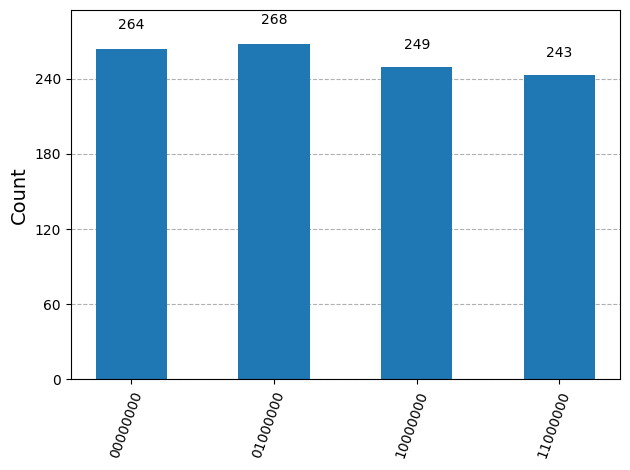

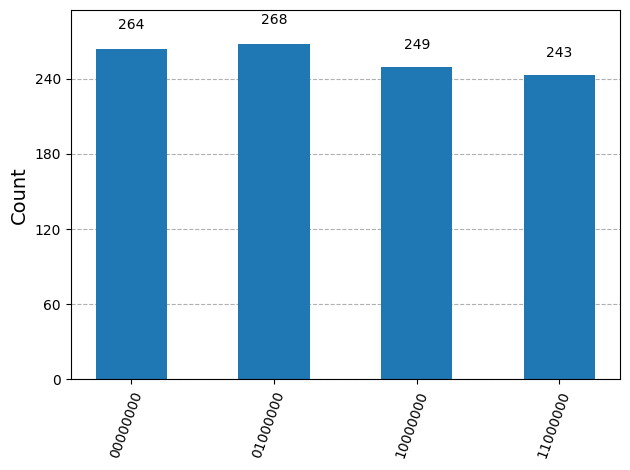

In [50]:
plot_histogram(counts)

By measuring the control qubits, we obtain an eight-bit phase estimation of the $M_a$ operator. We can convert this binary representation to decimal to find the measured phase. As we can see from the above histogram, four different bitstrings were measured, and each of them corresponds to a phase value as follows.



In [51]:
# Rows to be displayed in table
rows = []
# Corresponding phase of each bitstring
measured_phases = []

for output in counts:
    decimal = int(output, 2)  # Convert bitstring to decimal
    phase = decimal / (2**num_control)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(
        [
            f"{output}(bin) = {decimal:>3}(dec)",
            f"{decimal}/{2 ** num_control} = {phase:.2f}",
        ]
    )

# Print the rows in a table
headers = ["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


Recall that the any measured phase corresponds to $\theta = k / r$ where $k$ is sampled uniformly at random from $\{0, 1, \dots, r-1 \}$. Therefore, we can use the continued fractions algorithm to attempt to find $k$ and the order $r$. Python has this functionality built in. We can use the `fractions` module to turn a float into a `Fraction` object, for example:



In [52]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

Because this gives fractions that return the result exactly (in this case, `0.6660000...`), this can give gnarly results like the one above. We can use the `.limit_denominator()` method to get the fraction that most closely resembles our float, with a denominator below a certain value:



In [53]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

This is much nicer. The order (r) must be less than N, so we will set the maximum denominator to be `15`:



In [54]:
# Rows to be displayed in a table
rows = []

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append(
        [phase, f"{frac.numerator}/{frac.denominator}", frac.denominator]
    )

# Print the rows in a table
headers = ["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


We can see that two of the measured eigenvalues provided us with the correct result: $r=4$, and we can see that Shor’s algorithm for order finding has a chance of failing. These bad results are because $k = 0$, or because $k$ and $r$ are not coprime - and instead of $r$, we are given a factor of $r$. The easiest solution to this is to simply repeat the experiment until we get a satisfying result for $r$.



So far, we implemented the order finding problem for $N=15$ with $a=2$ using the phase estimation circuit on a simulator. The last step of Shor's algorithm will be to relate the order finding problem to the integer factorization problem. This last part of the algorithm is purely classical and can be solved on a classical computer after the phase measurements have been obtained from a quantum computer. Therefore, we defer the last part of the algorithm until after we demonstrate how we can run the order finding circuit on real hardware.



### Hardware runs



Now we can run the order finding circuit that we previously transpiled for `ibm_marrakesh`. Here we turn to [dynamical decoupling](/docs/guides/error-mitigation-and-suppression-techniques#dynamical-decoupling) (DD) for error suppression, and [gate twirling](/docs/guides/error-mitigation-and-suppression-techniques#pauli-twirling) for error mitigation purposes. DD involves applying sequences of precisely timed control pulses to a quantum device, effectively averaging out unwanted environmental interactions and decoherence. Gate twirling, on the other hand, randomizes specific quantum gates to transform coherent errors into Pauli errors, which accumulate linearly rather than quadratically. Both techniques are often combined to enhance the coherence and fidelity of quantum computations.



In [55]:
#results of a real quantum computer
counts={'00000100': 9, '01100000': 14, '11000000': 74, '00110000': 13, '00000000': 72, '11100010': 2, '00111010': 4, '11000100': 10, '11001010': 7, '11011100': 2, '10101010': 1, '10100000': 17, '10000110': 2, '10001000': 14, '00011000': 4, '00010000': 27, '10010100': 4, '11010000': 14, '10000100': 10, '01000001': 11, '01000010': 19, '10011011': 1, '00101010': 1, '00100010': 7, '11111000': 7, '00001000': 12, '01110000': 8, '10000000': 59, '01010000': 12, '00000001': 19, '01000000': 68, '10111011': 1, '01111010': 3, '00001010': 3, '01010010': 3, '00111000': 6, '01001010': 6, '00000010': 23, '10001001': 5, '00000011': 4, '11100000': 12, '10000101': 3, '00001100': 3, '11000011': 2, '11110100': 4, '11101000': 3, '01010001': 2, '11001001': 5, '10000001': 12, '01110001': 4, '10100010': 7, '01110010': 6, '11100110': 1, '10011000': 5, '01001011': 1, '01001100': 2, '00111100': 1, '00101101': 3, '11011000': 8, '10110001': 4, '01000100': 8, '11011001': 3, '10010000': 18, '11101001': 3, '00010011': 1, '01011000': 7, '10110111': 2, '11110001': 2, '01000101': 3, '00110100': 1, '01001000': 12, '00010101': 1, '10100100': 4, '01011100': 3, '11010100': 5, '10010111': 3, '11000101': 3, '11101101': 1, '01100010': 5, '11110000': 5, '10010001': 3, '11000001': 9, '00100001': 2, '10111100': 3, '01100100': 5, '01001001': 3, '00100000': 15, '10011010': 2, '00101000': 8, '01100110': 2, '01111000': 7, '00100011': 1, '10000010': 16, '10110110': 2, '00111001': 2, '11111010': 2, '01001101': 2, '11100100': 5, '00001011': 1, '11110101': 2, '10100001': 4, '01101101': 1, '10010110': 3, '10010011': 2, '10110101': 1, '11001000': 7, '11111100': 3, '10111000': 2, '11111011': 2, '11110011': 1, '11111111': 1, '11000110': 4, '00111011': 1, '00010010': 6, '01010100': 2, '01010011': 1, '00111110': 2, '10000011': 3, '01011001': 3, '11101100': 1, '01000110': 2, '11010010': 1, '10111111': 2, '00110010': 2, '00101110': 1, '11011011': 1, '01101111': 1, '10001011': 1, '00010100': 3, '11000010': 8, '01111001': 2, '11001100': 4, '10110000': 7, '11101011': 1, '00000101': 3, '10101011': 1, '01100001': 2, '00001001': 4, '11100001': 2, '00100100': 4, '11101010': 1, '10100101': 2, '00010001': 2, '11011101': 1, '11001111': 1, '11010111': 1, '00010110': 1, '11100101': 1, '01000011': 6, '11011110': 1, '10011001': 2, '11010101': 1, '10100110': 2, '10001110': 2, '10111101': 1, '10011100': 1, '01011111': 1, '01110011': 1, '00100110': 3, '10111001': 1, '10101100': 1, '11110110': 2, '01001110': 1, '00011010': 2, '10001010': 1, '10010101': 2, '10011110': 2, '10100111': 1, '11010001': 1, '10101000': 3, '01011110': 1, '00111101': 2, '00101100': 1, '00100101': 2, '11010011': 1, '10100011': 1, '11111110': 1, '11101110': 2, '01110100': 1, '00001110': 2, '11000111': 1, '00011001': 1, '00110011': 1, '11001011': 1, '10101110': 1, '11110010': 2, '00011100': 1, '00011110': 1, '00000110': 1, '10001100': 1, '00001101': 1}

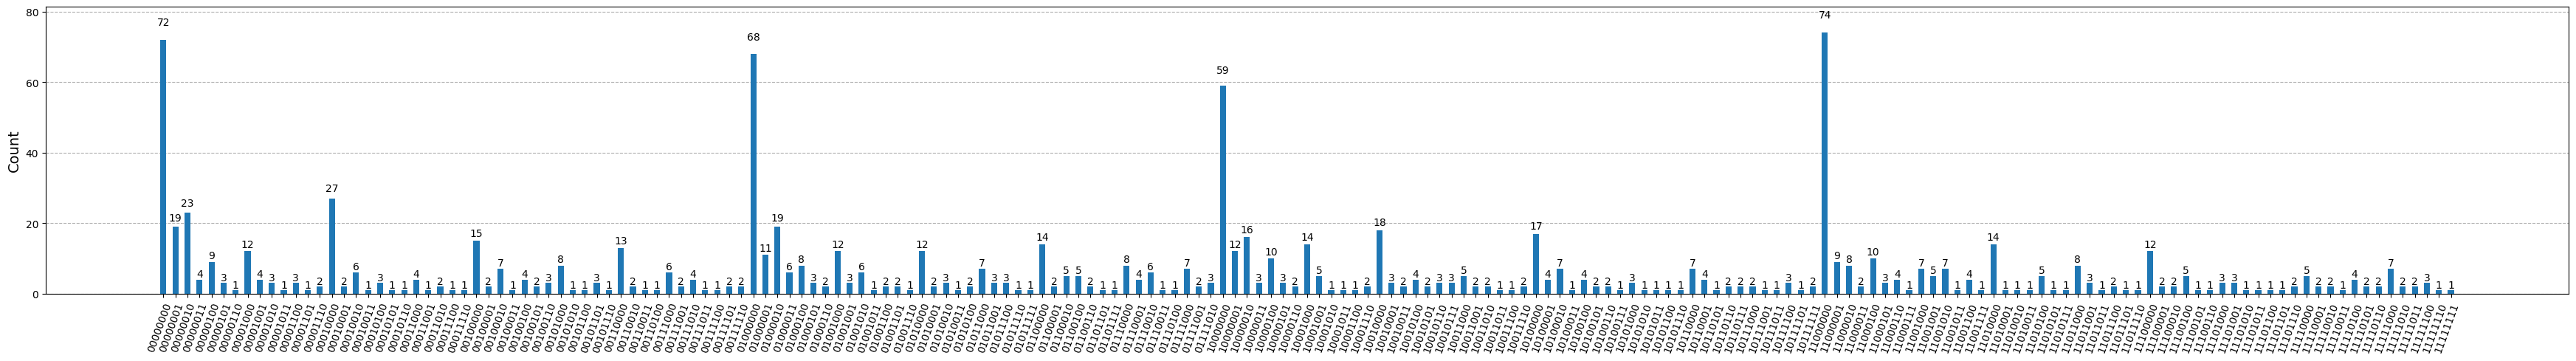

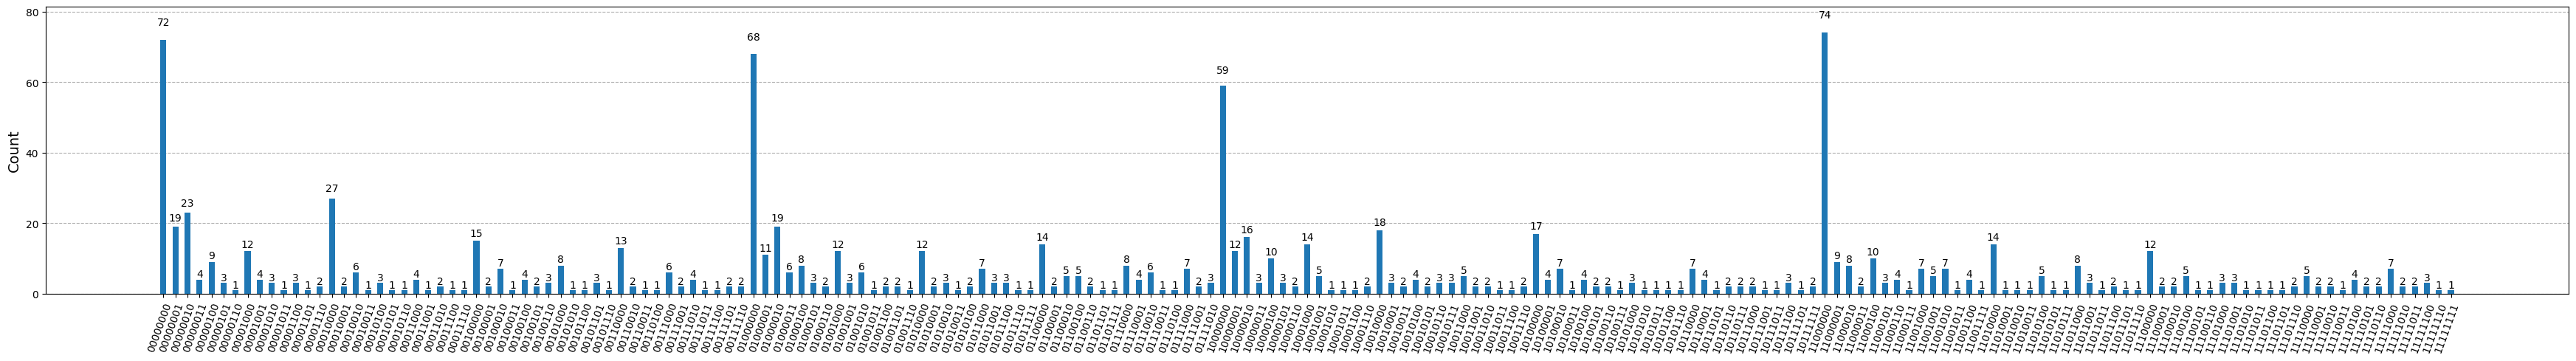

In [56]:
plot_histogram(counts, figsize=(35, 5))

As we can see, we obtained the same bitstrings with highest counts. Since quantum hardware has noise, there is some leakage to other bitstrings, which we can filter out statistically.



In [57]:
# Dictionary of bitstrings and their counts to keep
counts_keep = {}
# Threshold to filter
threshold = np.max(list(counts.values())) / 2

for key, value in counts.items():
    if value > threshold:
        counts_keep[key] = value

print(counts_keep)

{'11000000': 74, '00000000': 72, '10000000': 59, '01000000': 68}


## Step 4: Post-process and return result in desired classical format



### Integer Factorization



So far, we discussed how we can implement the order finding problem using a phase estimation circuit. Now, we connect the order finding problem to integer factorization, which completes Shor's algorithm. Note that this part of the algorithm is classical.



We now demonstrate this using our example of $N = 15$ and $a = 2$. Recall that the phase we measured is $k / r$, where $a^r \; (\textrm{mod} \; N) = 1$ and $k$ is a random integer between $0$ and $r - 1$. From this equation, we have $(a^r - 1) \; (\textrm{mod} \; N) = 0,$ which means $N$ must divide $a^r-1$. If $r$ is also even, then we can write $a^r -1 = (a^{r/2}-1)(a^{r/2}+1).$ If $r$ is not even, we cannot go further and must try again with a different value for $a$; otherwise, there is a high probability that the greatest common divisor of $N$ and either $a^{r/2}-1$, or $a^{r/2}+1$ is a proper factor of $N$.

Since some runs of the algorithm will statistically fail, we will repeat this algorithm until at least one factor of $N$ is found.



The cell below repeats the algorithm until at least one factor of $N=15$ is found. We will use the results of the hardware run above to guess the phase and the corresponding factor in each iteration.



In [58]:
a = 2
N = 15

FACTOR_FOUND = False
num_attempt = 0

while not FACTOR_FOUND:
    print(f"\nATTEMPT {num_attempt}:")
    # Here, we get the bitstring by iterating over outcomes
    # of a previous hardware run with multiple shots.
    # Instead, we can also perform a single-shot measurement
    # here in the loop.
    bitstring = list(counts_keep.keys())[num_attempt]
    num_attempt += 1
    # Find the phase from measurement
    decimal = int(bitstring, 2)
    phase = decimal / (2**num_control)  # phase = k / r
    print(f"Phase: theta = {phase}")

    # Guess the order from phase
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator  # order = r
    print(f"Order of {a} modulo {N} estimated as: r = {r}")

    if phase != 0:
        # Guesses for factors are gcd(a^{r / 2} ± 1, 15)
        if r % 2 == 0:
            x = pow(a, r // 2, N) - 1
            d = gcd(x, N)
            if d > 1:
                FACTOR_FOUND = True
                print(f"*** Non-trivial factor found: {x} ***")


ATTEMPT 0:
Phase: theta = 0.75
Order of 2 modulo 15 estimated as: r = 4
*** Non-trivial factor found: 3 ***


### Related work

In this section, we discuss other milestone work that has demonstrated Shor's algorithm on real hardware.

The seminal work [\[3\]](#references) from IBM® demonstrated Shor's algorithm for the first time, factoring the number 15 into its prime factors 3 and 5 using a seven-qubit nuclear magnetic resonance (NMR) quantum computer. Another experiment [\[4\]](#references) factored 15 using photonic qubits. By employing a single qubit recycled multiple times and encoding the work register in higher-dimensional states, the researchers reduced the required number of qubits to one-third of that in the standard protocol, utilizing a two-photon compiled algorithm. A significant paper in the demonstration of Shor's algorithm is [\[5\]](#references), which uses Kitaev's iterative phase estimation [\[8\]](#references) technique to reduce the qubit requirement of the algorithm. Authors used seven control qubits and four cache qubits, together with the implementation of modular multipliers. This implementation, however, requires mid-circuit measurements with feed-forward operations and qubit recycling with reset operations. This demonstration was done on an ion-trap quantum computer.

More recent work [\[6\]](#references) focused on factoring 15, 21, and 35 on IBM Quantum® hardware. Similar to previous work, researchers used a compiled version of the algorithm that employed a semi-classical quantum Fourier transform as proposed by Kitaev to minimize the number of physical qubits and gates. A most recent work [\[7\]](#references) also performed a proof-of-concept demonstration for factoring the integer 21. This demonstration also involved the use of a compiled version of the quantum phase estimation routine, and built upon the previous demonstration by [\[4\]](#references). Authors went beyond this work by using a configuration of approximate Toffoli gates with residual phase shifts. The algorithm was implemented on IBM quantum processors using only five qubits, and the presence of entanglement between the control and register qubits was verified successfully.



### Scaling of the algorithm

We note that RSA encryption typically involves key sizes on the order of 2048 to 4096 bits. Attempting to factor a 2048-bit number with Shor's algorithm will result in a quantum circuit with millions of qubits, including the error correction overhead and a circuit depth on the order of a billion, which is beyond the limits of current quantum hardware to execute. Therefore, Shor's algorithm will require either optimized circuit construction methods or robust quantum error correction to be practically viable for breaking modern cryptographic systems. We refer you to [\[9\]](#references) for a more detailed discussion on resource estimation for Shor's algorithm.



## References

1.  Shor, Peter W. "[Polynomial-time algorithms for prime factorization and discrete logarithms on a quantum computer](https://epubs.siam.org/doi/abs/10.1137/S0036144598347011)." SIAM review 41.2 (1999): 303-332.
2.  IBM Quantum [Fundamentals of Quantum Algorithms](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring) course by Dr. John Watrous.
3.  Vandersypen, Lieven MK, et al. "[Experimental realization of Shor's quantum factoring algorithm using nuclear magnetic resonance](https://www.nature.com/articles/414883a)." Nature 414.6866 (2001): 883-887.
4.  Martin-Lopez, Enrique, et al. "[Experimental realization of Shor's quantum factoring algorithm using qubit recycling](https://www.nature.com/articles/nphoton.2012.259)." Nature photonics 6.11 (2012): 773-776.
5.  Monz, Thomas, et al. "[Realization of a scalable Shor algorithm](https://www.science.org/doi/full/10.1126/science.aad9480)." Science 351.6277 (2016): 1068-1070.
6.  Amico, Mirko, Zain H. Saleem, and Muir Kumph. "[Experimental study of Shor's factoring algorithm using the IBM Q Experience](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.100.012305)." Physical Review A 100.1 (2019): 012305.
7.  Skosana, Unathi, and Mark Tame. "[Demonstration of Shor’s factoring algorithm for N=21 on IBM quantum processors](https://www.nature.com/articles/s41598-021-95973-w)." Scientific reports 11.1 (2021): 16599.
8.  Kitaev, A. Yu. "[Quantum measurements and the Abelian stabilizer problem](https://arxiv.org/abs/quant-ph/9511026)." arXiv preprint quant-ph/9511026 (1995).
9.  Gidney, Craig, and Martin Ekerå. "[How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits](https://doi.org/10.22331/q-2021-04-15-433)." Quantum 5 (2021): 433.



© IBM Corp., 2017-2025